# **Linear Classification with CUDA** - Arnaud Aillaud

---


Results are presented in the `Experiments` and `Conclusion` sections

# Installation

In [1]:
!/usr/local/cuda/bin/nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0


Download repository with helper_cuda.h:

In [2]:
!git clone https://github.com/NVIDIA/cuda-samples.git

Cloning into 'cuda-samples'...
remote: Enumerating objects: 14786, done.
remote: Counting objects: 100% (4178/4178), done.
remote: Compressing objects: 100% (718/718), done.
remote: Total 14786 (delta 3694), reused 3736 (delta 3457), pack-reused 10608
Receiving objects: 100% (14786/14786), 132.88 MiB | 18.09 MiB/s, done.
Resolving deltas: 100% (12463/12463), done.
Updating files: 100% (3941/3941), done.


Based on the lecture at https://sites.google.com/site/frehseg/teaching/ia307

# Provided Code

## CUDA Utilities

In [3]:
%%writefile cuda_stuff.cuh
#include <stdio.h>
#include <stdlib.h>
#include <cuda.h>
#include <cuda_runtime.h>
#include <helper_cuda.h>

#ifndef cuda_stuff_H
#define cuda_stuff_H

/* transform matrix index to vector offset
   Since CUDA uses column major, 
   nb_rows = number of rows */
#define IDX2C(i,j,nb_rows) (((j)*(nb_rows))+(i))
 
//MACRO TO DEBUGG CUDA FUNCTIONS
/** Error checking,
 *  taken from https://stackoverflow.com/questions/14038589/what-is-the-canonical-way-to-check-for-errors-using-the-cuda-runtime-api
 */
#define gpuErrchk(ans) { gpuAssert((ans), __FILE__, __LINE__); }
inline void gpuAssert(cudaError_t code, const char *file, int line, bool abort=true)
{
   if (code != cudaSuccess) 
   {
      fprintf(stderr,"GPUassert: %s %s %d\n", cudaGetErrorString(code), file, line);
      if (abort) exit(code);
   }
}
/** Error checking for use with CUDA Dynamic Parallelism */
/*
#define cdpErrchk(ans) { cdpAssert((ans), __FILE__, __LINE__); }
__device__ void cdpAssert(cudaError_t code, const char *file, int line, bool abort=true)
{
   if (code != cudaSuccess)
   {
      printf("GPU kernel assert: %s %s %d\n", cudaGetErrorString(code), file, line);
      if (abort) assert(0);
   }
}
*/
void device_synchronize();

#endif


Writing cuda_stuff.cuh


In [4]:
%%writefile cuda_stuff.cu
#include <stdio.h>
#include <stdlib.h>
#include <cuda.h>
#include <cuda_runtime.h>
#include <helper_cuda.h>
#include "cuda_stuff.cuh"

void device_synchronize(){
    gpuErrchk(cudaDeviceSynchronize());
}

Writing cuda_stuff.cu


## fmatrix Matrix Tools

In [5]:
%%writefile fmatrix.cuh
#ifndef fmatrices_H
#define fmatrices_H
#include "cuda_stuff.cuh" // for IDX2C

typedef struct {
    float* data;
    int cols;
    int rows;
} fmatrix;

/* Access element (i,j) of matrix mat */
#define getfm(mat,i,j) (mat.data[IDX2C(i,j,mat.rows)])


int fmatrix_elements(fmatrix mat);
int fmatrix_size(fmatrix mat);
/** Assert that the matrix is coherent: all fields nonzero. */
void fmatrix_assert(fmatrix mat);

fmatrix fmatrix_create_on_host(int rows, int cols);
fmatrix fmatrix_create_on_device(int rows, int cols);
void fmatrix_data_to_host(fmatrix mat_host, fmatrix mat_device);
void fmatrix_data_to_device(fmatrix mat_host, fmatrix mat_device);
fmatrix fmatrix_copy_to_host(fmatrix mat_host);
fmatrix fmatrix_copy_to_device(fmatrix mat_host);
void fmatrix_free_on_host(fmatrix* mat);
void fmatrix_free_on_device(fmatrix* mat);

/** Create a matrix representing columns [a,b) of M. 
 *  Note that the new matrix points into the
 *  data of M. The data is not copied to a new location.
 */
fmatrix fmatrix_subcolumns(fmatrix M, int a, int b);

/** Print the first nb rows of the matrix mat
 *  on the host. 
 *  If nb<0, print all rows. 
 *
 * @attention: Works in device code if mat is on the device
 * and works in host code if mat is on the host.
 * All other cases require transferring the data first. 
 */
 __host__
 __device__
void fmatrix_print(fmatrix mat, int nb=-1);

/** Print the first nb rows of the matrix mat
 *  on the device. 
 *  If nb<0, print all rows. 
 *
 *  This version copies the matrix to host first.
 */
void fmatrix_device_print(fmatrix mat, int nb=-1);

#endif


Writing fmatrix.cuh


In [6]:
%%writefile fmatrix.cu
#include <assert.h>
#include <stdio.h>
#include <stdlib.h>
#include <cuda.h>
#include <cuda_runtime.h>
#include <helper_cuda.h>
#include "cuda_stuff.cuh"
#include "fmatrix.cuh"

int fmatrix_elements(fmatrix mat) {
     return mat.cols*mat.rows;
}

int fmatrix_size(fmatrix mat) {
    // the following is only valid if matrix data already allocated,
    // so it can't be used in create_on_... functions
    // return fmatrix_elements(mat) * sizeof(mat.data[0]);
    return fmatrix_elements(mat) * sizeof(float);
}

void fmatrix_assert(fmatrix mat) {
    assert(mat.data);
    assert(mat.cols);
    assert(mat.rows);
}

fmatrix fmatrix_create_on_host(int rows, int cols) {
    assert(cols>0);
    assert(rows>0);
    fmatrix mat;
    mat.cols = cols;
    mat.rows = rows;
    mat.data = (float*)malloc(fmatrix_size(mat)); 
    assert(mat.data);
    return mat;
}

fmatrix fmatrix_create_on_device(int rows, int cols) {
    assert(cols>0);
    assert(rows>0);
    fmatrix mat;
    mat.cols = cols;
    mat.rows = rows;
    gpuErrchk( 
        cudaMalloc((void **)&(mat.data), fmatrix_size(mat)) 
    );
    return mat;
}

void fmatrix_data_to_device(fmatrix mat_host, fmatrix mat_device) {
    fmatrix_assert(mat_host);
    fmatrix_assert(mat_device);
    assert(mat_host.cols==mat_device.cols);
    assert(mat_host.rows==mat_device.rows);
    gpuErrchk( 
        cudaMemcpy( mat_device.data, mat_host.data, 
                   fmatrix_size(mat_host), 
                   cudaMemcpyHostToDevice 
                   )
        );
}

void fmatrix_data_to_host(fmatrix mat_host, fmatrix mat_device) {
    fmatrix_assert(mat_host);
    fmatrix_assert(mat_device);
    assert(mat_host.cols==mat_device.cols);
    assert(mat_host.rows==mat_device.rows);
    gpuErrchk(
        cudaMemcpy( mat_host.data, mat_device.data,  
                   fmatrix_size(mat_device), 
                   cudaMemcpyDeviceToHost 
                   )
        );
}

fmatrix fmatrix_copy_to_host(fmatrix mat_device) {
    fmatrix_assert(mat_device);
    fmatrix mat_host = fmatrix_create_on_host(mat_device.rows, mat_device.cols);
    fmatrix_data_to_host(mat_host,mat_device);
    return mat_host;
}

fmatrix fmatrix_copy_to_device(fmatrix mat_host) {
    fmatrix_assert(mat_host);
    fmatrix mat_device = fmatrix_create_on_device(mat_host.rows, mat_host.cols);
    fmatrix_data_to_device(mat_host,mat_device);
    return mat_device;
}

void fmatrix_free_on_host(fmatrix* mat) {
    fmatrix_assert(*mat);  
  free(mat->data);
  mat->data = 0;
  mat->cols = 0;
  mat->rows = 0;
}

void fmatrix_free_on_device(fmatrix* mat) {
    fmatrix_assert(*mat);  
  gpuErrchk(cudaFree(mat->data));
  mat->data = 0;
  mat->cols = 0;
  mat->rows = 0;
}

fmatrix fmatrix_subcolumns(fmatrix M, int a, int b) {
    fmatrix_assert(M);  
    fmatrix A = { 
        .data = &getfm(M,0,a),  
        .cols = b-a,
        .rows = M.rows 
    };
    fmatrix_assert(A);  
    return A;
}


__host__
__device__
void fmatrix_print(fmatrix mat, int nb){
    if (nb<0 || nb > mat.rows) {
        nb = mat.rows;
    }
    printf("[\n");
    for (int i = 0 ; i < nb; i++){
      for (int j = 0 ; j<mat.cols; j++){
        printf("%f", getfm(mat,i,j));
        if (j+1<mat.cols) {
          printf(",\t");
        }
      }
      if (i+1<nb) {
        printf(";\n");
      }
    }
    if (nb < mat.rows) {
      printf("\n...\n");
    }
  printf("\n]\n");
}

void fmatrix_device_print(fmatrix mat, int nb){
   // allocate copy
   fmatrix tmp = fmatrix_copy_to_host(mat);
   fmatrix_print(tmp,nb);
   fmatrix_free_on_host(&tmp);
}



Writing fmatrix.cu


## Data I/O

In [7]:
%%writefile read_csv.cuh
#include <cuda_runtime.h>
#ifndef read_csv_H
#define read_csv_H

void read_csv(const char* filename, float* data_array,int nbrow,int nbcol);

#endif

Writing read_csv.cuh


In [8]:
%%writefile read_csv.cu
#include <stdio.h>
#include <stdlib.h>
#include <string.h>

#include <iostream>
#include <iomanip>
#include <math.h>
#include <fstream>

#include "read_csv.cuh"
#include "cuda_stuff.cuh" // for matrix indexing

using namespace std;

/////////////////////////////////////////////////////////
// Functions for reading the dataset from a file
/////////////////////////////////////////////////////////

/* Read a csv file with a given number of rows and columns */
void read_csv(const char* filename, float* data_array,int nbrow,int nbcol) {
  string row_as_string;
  string value;
  double ioTemp;
  ifstream infile;
  infile.open(filename, ifstream::in);
  int row_count = 0;
	if (infile.is_open())
  {
      // read the headers (and discard)
			getline(infile, row_as_string, '\n');
      cout << "headers: " << row_as_string << "!" << std::endl;
      for(int i = 0; i < nbrow; i++){
  			getline(infile, row_as_string, '\n');
        // cout << "read line " << row_as_string << "!" << std::endl;
				istringstream line_stream(row_as_string);
			  for(int j = 0; j < nbcol; j++){
          getline(line_stream, value, ',');
					ioTemp = strtod(value.c_str(), NULL); 
          // cout << "("<<i<<","<<j<<") = "<< ioTemp << std::endl;

					data_array[IDX2C(i,j,nbrow)] = ioTemp;

				}
        ++row_count;
			}
		infile.close();
    cout << "Read " << row_count << " rows." << std::endl;
	}
	else cout << "Cannot open file." << endl;
}

Writing read_csv.cu


In [9]:
%%writefile preprocess_data.cuh
#include <cuda_runtime.h>
#ifndef preprocess_data_H
#define preprocess_data_H

void get_inputs_and_labels(float* data_array, float** input_array, float** label_array, int nbrows, int nbcols, int nb_inputs, int nb_labels );

#endif

Writing preprocess_data.cuh


In [10]:
%%writefile preprocess_data.cu
#include <stdio.h>
#include <stdlib.h>
#include <string.h>

#include <iostream>
#include <iomanip>
#include <math.h>
#include <fstream>

/*Matrix multiplication functions and other auxiliary functions*/
#include "preprocess_data.cuh"

using namespace std;

/* transform matrix index to vector offset
   Since CUDA uses column major, 
   ld = number of rows 
   Example of use: a[IDX2C(0, 1, 50)] */
#define IDX2C(i,j,ld) (((j)*(ld))+(i))

//Number of thread per block
#define THREADS_PER_BLOCK 1024
/* Constants for housing data set */
#define data_columns  (9)
#define above_threshold (265000.0)

/////////////////////////////////////////////////////////
// Number of rows in arrays to print for debugging
/////////////////////////////////////////////////////////
#define print_rows (10)
/////////////////////////////////////////////////////////
// Functions for preprocessing the data set
/////////////////////////////////////////////////////////

/* Split data into inputs and labels. Allocated memory for inputs and labels.
   Since cuBLAS is column major, each input is in a column.
   We also add 1.0 as first element to each input vector.
*/
void get_inputs_and_labels(float* data_array, float** input_array, float** label_array, int nbrows, int nbcols, int nb_inputs, int nb_labels ) {
    // The inputs are the first nbrows-1 columns.
    // The labels are the last column (index nbrows-1), booleanized
    // by the condition >= above_threshold
    *input_array = (float *)malloc(nbrows * nb_inputs * sizeof(float));    
    *label_array = (float *)malloc(nbrows * nb_labels * sizeof(float));    
    //cout << &input_array << " and "<< &label_array << " data " << data_array << std::endl;
    cout << "Allocated memory for inputs: " << nbrows << " rows, "<< nb_inputs << " columns." << std::endl;
    cout << "Allocated memory for labels: " << nbrows << " rows, "<< nb_labels << " columns." << std::endl;

    // Copy the data to X
    for(int i = 0; i < nbrows; i++){
      // Set the first element of each x to 1  
      (*input_array)[IDX2C(0,i,nb_inputs)] = 1.0;
      // Copy the rest of x
			for(int j = 1; j < nb_inputs; j++){
				(*input_array)[IDX2C(j,i,nb_inputs)] = data_array[IDX2C(i,j-1,nbrows)];
			}
      float median_house_value = data_array[IDX2C(i,nbcols-1,nbrows)];
      (*label_array)[IDX2C(0,i,nb_labels)] = 0.0;
      (*label_array)[IDX2C(1,i,nb_labels)] = 0.0;
      if (median_house_value >= above_threshold) {
        (*label_array)[IDX2C(0,i,nb_labels)] = 1.0;
      } else {
        (*label_array)[IDX2C(1,i,nb_labels)] = 1.0;        
      }
		}    
    
    // Show some entries for double checking
    cout << "Inputs (first "<<print_rows<<"):" << std::endl;
	  for(int j = 0; j < nb_inputs; j++){
      for(int i = 0; i < nbrows && i < print_rows; i++){
				cout << (*input_array)[IDX2C(j,i,nb_inputs)] << "\t";
			}
      cout << "\n";
		}
    cout << "Labels (first "<<print_rows<<"):" << std::endl;
    for(int j = 0; j < nb_labels; j++){
      for(int i = 0; i < nbrows && i < print_rows; i++){
				cout << (*label_array)[IDX2C(j,i,nb_labels)] << "\t";
			}
      cout << "\n";
		}
}

Writing preprocess_data.cu


# Code That You Write

## Classifier Math

In [11]:
%%writefile classifier_math.cuh
#ifndef classifier_math_H
#define classifier_math_H

#include "fmatrix.cuh"
#include "cublas_v2.h"

/** Returns a random float between min and max (including). */
float float_rand( float min, float max );

/** Initialize W with Xavier's method,
 *  scaled by a. */
void xavier_weight_init(float a, fmatrix W);

/** Compute the softmax for each column of Z and store in P **/
void softmax_col(fmatrix P, fmatrix Z); 

///////////////////////////////////
// TO BE COMPLETED
// ... add your matrix math here
///////////////////////////////////
void cublas_mult(float alpha, cublasOperation_t transa, cublasOperation_t transb, fmatrix d_A, fmatrix d_B, float beta, fmatrix d_C);
void fmatrix_add(fmatrix P, float a, fmatrix Y);

// Computes mean and standard deviation of matrix X
fmatrix *compute_moments(fmatrix X);
/** Normalize matrix X with mean mu and standard deviation sigma
If bias is 1, the 1st column is not normalized (let at 1 values for bias) **/
void normalize(fmatrix X, fmatrix mu, fmatrix sigma, int bias);

// Shuffles the columns of matrices X and Y (useful for minibatch)
// Somewhat slow ...
void fmatrix_shuffle_col(fmatrix X, fmatrix Y, int seed);

#endif

Writing classifier_math.cuh


For the computation of the variance in the normalization, the following form was used : <br>
$
\begin{align*}
Var(X) &= \mathbb{E}[x^2] - (\mathbb{E}[x])^2 \\
\Rightarrow Var(X) &= \frac{1}{n}\sum_{i=0}^n x_i^2 - \mu^2
\end{align*}
$

In [12]:
%%writefile classifier_math.cu
#include "classifier_math.cuh"
#include "cuda_stuff.cuh"
#include <cuda.h>
#include <cuda_runtime.h>
#include <helper_cuda.h>
#include <math.h>
#include <assert.h>
#include <float.h>
#include <sys/time.h>
#include <curand.h>
#include <curand_kernel.h>
#include <thrust/shuffle.h>


#define THREADS_PER_BLOCK 1024

static cublasHandle_t handle; 
static int cublas_init = 0;

/////////////////////////////////////////////////////////
// Auxiliary function
/////////////////////////////////////////////////////////
// generate random numbers in interval [min,max]
float float_rand( float min, float max )
{
    float scale = rand() / (float) RAND_MAX; /* [0, 1.0] */
    return min + scale * ( max - min );      /* [min, max] */
}

void xavier_weight_init(float a, fmatrix W){
    for (int j = 0; j < W.rows  ; ++j) {
      for (int i = 0; i < W.cols  ; ++i) {
          getfm(W,j,i) = a * (1.0/sqrt(W.cols+W.rows)) * float_rand(-1.0,1.0);
      }
    }
}


/////////////////////////////////////////////////////////
// Stable Softmax
/////////////////////////////////////////////////////////
__global__ 
void fmatrix_colmax_kernel(fmatrix Z, fmatrix tmp) {
    int i = blockIdx.x * blockDim.x + threadIdx.x;
    if (i < Z.cols ){
        // Initialise the max with value of first row
        float Zmax = getfm(Z, 0, i);
        for (int j = 1; j < Z.rows; j++) {
            if(getfm(Z, j, i) > Zmax) {
                Zmax = getfm(Z, j, i);
            }
        }
        getfm(tmp, 0, i) = Zmax;
    }
}

__global__ 
void fmatrix_exp_kernel(fmatrix P, fmatrix Z, fmatrix tmp) {
    assert(P.cols==Z.cols);
    assert(P.rows==Z.rows);
    assert(tmp.cols==Z.cols);

    int idx = blockIdx.x * blockDim.x + threadIdx.x;
    int j = idx / P.rows;
    int i = idx % P.rows;

    // Chaque thread calcule l'exponentiel d'un élément de la matrice
    if (i < P.rows && j < P.cols ){
        getfm(P, i, j) = __expf(getfm(Z, i, j) - getfm(tmp, 0, j));
    }
}

__global__ 
void fmatrix_colnormalize_kernel(fmatrix P) {
    int i = blockIdx.x * blockDim.x + threadIdx.x;
    float tmp_p = 0.0;
    if (i < P.cols ){
        for (int j = 0; j<P.rows; j++) {
            tmp_p += getfm(P, j, i);
        }
        for (int j = 0; j<P.rows; j++) {
            getfm(P, j, i) = getfm(P, j, i) / tmp_p;
        }
    }
}

/** Compute stable softmax of Z and stores in P **/
void softmax_col(fmatrix P, fmatrix Z) {
    fmatrix_assert(Z);

    // First kernel : computes the max of each column of Z, and returns (zi - zkmax) in tmp vector
    // Each thread loads one column of Z
    fmatrix tmp = fmatrix_create_on_device(1, Z.cols);
    int threadsPerBlock3 = Z.cols;
    int blocksPerGrid = 1;
    if (threadsPerBlock3 > THREADS_PER_BLOCK){
        blocksPerGrid = (threadsPerBlock3-1)/THREADS_PER_BLOCK + 1;
        threadsPerBlock3 = THREADS_PER_BLOCK;
    }
    fmatrix_colmax_kernel<<< blocksPerGrid, threadsPerBlock3 >>>(Z, tmp);
    gpuErrchk( cudaPeekAtLastError() );
    device_synchronize();

    // Second kernel : computes exponential of each element of matrix Z - zkmax and stores in P
    // Each thread loads one element of Z
    int threadsPerBlock = fmatrix_elements(Z);
    blocksPerGrid = 1;
    if (threadsPerBlock > THREADS_PER_BLOCK){
        blocksPerGrid = (threadsPerBlock-1)/THREADS_PER_BLOCK + 1;
        threadsPerBlock = THREADS_PER_BLOCK;
    }
    fmatrix_exp_kernel<<< blocksPerGrid, threadsPerBlock >>>(P, Z, tmp);
    gpuErrchk( cudaPeekAtLastError() );
    device_synchronize();
    // tmp matrix is no longer useful from here on
    fmatrix_free_on_device(&tmp);

    // Third kernel : normalizes P by the sum of each column
    // Each thread loads one column of P
    int threadsPerBlock2 = P.cols;
    blocksPerGrid = 1;
    if (threadsPerBlock2 > THREADS_PER_BLOCK){
        blocksPerGrid = (threadsPerBlock2-1)/THREADS_PER_BLOCK + 1;
        threadsPerBlock2 = THREADS_PER_BLOCK;
    }
    fmatrix_colnormalize_kernel<<< blocksPerGrid, threadsPerBlock2 >>>(P);
    gpuErrchk( cudaPeekAtLastError() );
    device_synchronize();
}

/////////////////////////////////////////////////////////
// Normalisation
/////////////////////////////////////////////////////////

__global__ 
void fmatrix_compute_moments(fmatrix X, fmatrix mu, fmatrix sigma) {
    int i = blockIdx.x * blockDim.x + threadIdx.x;
    if (i < X.rows ){
        // Initialise the moments with values of first column
        getfm(mu, i, 0) = getfm(X, i, 0);
        getfm(sigma, i, 0) = powf(getfm(X, i, 0), 2.0);
        for (int j = 1; j < X.cols; j++) {
            getfm(mu, i, 0) += getfm(X, i, j);
            getfm(sigma, i, 0) += powf(getfm(X, i, j), 2.0);
        }
        getfm(mu, i, 0) /= X.cols;
        getfm(sigma, i, 0) = sqrt(getfm(sigma, i, 0) / X.cols - powf(getfm(mu, i, 0), 2.0));
    }
}


__global__ 
void fmatrix_normalize_kernel(fmatrix X, fmatrix mu, fmatrix sigma, int bias) {
    assert(X.rows==mu.rows);
    assert(X.rows==sigma.rows);

    int idx = blockIdx.x * blockDim.x + threadIdx.x;
    int j = idx / X.rows;
    int i = idx % X.rows;

    // Chaque thread normalise un élément de la matrice
    if (bias == 1) {
        if (i > 0 && i < X.rows && j < X.cols ){
            getfm(X, i, j) = (getfm(X, i, j) - getfm(mu, i, 0)) / getfm(sigma, i, 0);
        }
    } else {
        if (i < X.rows && j < X.cols ){
            getfm(X, i, j) = (getfm(X, i, j) - getfm(mu, i, 0)) / getfm(sigma, i, 0);
        }
    }
}


/** Compute mean and standard deviation of matrix X **/
fmatrix *compute_moments(fmatrix X) {
    fmatrix_assert(X);

    // Initialise mu, sigma and array to return the vectors
    fmatrix mu = fmatrix_create_on_device(X.rows, 1);
    fmatrix sigma = fmatrix_create_on_device(X.rows, 1);
    static fmatrix moments[2];

    // Each thread loads one row of X
    int threadsPerBlock = X.rows;
    int blocksPerGrid = 1;
    if (threadsPerBlock > THREADS_PER_BLOCK){
        blocksPerGrid = (threadsPerBlock-1)/THREADS_PER_BLOCK + 1;
        threadsPerBlock = THREADS_PER_BLOCK;
    }
    fmatrix_compute_moments<<< blocksPerGrid, threadsPerBlock >>>(X, mu, sigma);
    gpuErrchk( cudaPeekAtLastError() );
    device_synchronize();

    moments[0] = mu;
    moments[1] = sigma;
    return moments;
}

/** Normalize matrix X with mean mu and standard deviation sigma
If bias is 1, the 1st column is not normalized (let at 1 values for bias) **/
void normalize(fmatrix X, fmatrix mu, fmatrix sigma, int bias) {
    fmatrix_assert(X);
    fmatrix_assert(mu);
    fmatrix_assert(sigma);

    // Each thread loads one element of X
    int threadsPerBlock = fmatrix_elements(X);
    int blocksPerGrid = 1;
    if (threadsPerBlock > THREADS_PER_BLOCK){
        blocksPerGrid = (threadsPerBlock-1)/THREADS_PER_BLOCK + 1;
        threadsPerBlock = THREADS_PER_BLOCK;
    }
    fmatrix_normalize_kernel<<< blocksPerGrid, threadsPerBlock >>>(X, mu, sigma, bias);
    gpuErrchk( cudaPeekAtLastError() );
    device_synchronize();

}

/////////////////////////////////////////////////////////
// Matrix Operations
/////////////////////////////////////////////////////////
void cublas_mult(float alpha, cublasOperation_t transa, cublasOperation_t transb, fmatrix d_A, fmatrix d_B, float beta, fmatrix d_C){
  // Check cuBLAS initialisation
  if (cublas_init == 0){
    cublasCreate(&handle);
    cublas_init = 1;
  }

  int k;
  if (transa == CUBLAS_OP_N){
    k = d_A.cols;
  } else {
    k = d_A.rows;
  }

  cublasSgemm(handle, transa, transb, d_C.rows, d_C.cols, k, &alpha, d_A.data,
    d_A.rows, d_B.data, d_B.rows, &beta, d_C.data, d_C.rows);
}


__global__ 
void fmatrix_add_kernel(fmatrix P, float a, fmatrix Y) {
    int idx = blockIdx.x * blockDim.x + threadIdx.x;
    int j = idx / P.rows;
    int i = idx % P.rows;
    if (i < P.rows && j < P.cols ){
        getfm(P,i,j) += a * getfm(Y,i,j);
    }
}

/** Compute P = P + a*Y */
void fmatrix_add(fmatrix P, float a, fmatrix Y) {
    fmatrix_assert(P);
    fmatrix_assert(Y);
    assert(P.rows == Y.rows);
    assert(P.cols == Y.cols);
    int threadsPerBlock = fmatrix_elements(P);
    int blocksPerGrid = 1;
    if (threadsPerBlock > THREADS_PER_BLOCK){
        blocksPerGrid = (threadsPerBlock-1)/THREADS_PER_BLOCK + 1;
        threadsPerBlock = THREADS_PER_BLOCK;
    }
    fmatrix_add_kernel<<< blocksPerGrid, threadsPerBlock >>>(P,a,Y);
    gpuErrchk( cudaPeekAtLastError() );
}

/////////////////////////////////////////////////////////
// Matrix shuffle
/////////////////////////////////////////////////////////

__global__ 
void copy_to_tmp_kernel(fmatrix X, fmatrix tmp_X) {
    int idx = blockIdx.x * blockDim.x + threadIdx.x;
    int j = idx / X.rows;
    int i = idx % X.rows;

    if (i < X.rows && j < X.cols ){
        getfm(tmp_X, i, j) = getfm(X, i, j);
    }
}

__global__ 
void swap_columns_kernel(fmatrix X, fmatrix tmp_X, fmatrix Y, fmatrix tmp_Y, int* indices) {
    int i = blockIdx.x * blockDim.x + threadIdx.x;

    if (i < X.cols){
      int rand = indices[i];
      // Loop over rows in X and Y (only 9 rows for X and 2 for Y, which is fine for a GPU core)
      for (int j = 0; j < X.rows; j++){
        getfm(X, j, i) = getfm(tmp_X, j, rand);
      }
      for (int j = 0; j < Y.rows; j++){
        getfm(Y, j, i) = getfm(tmp_Y, j, rand);
      }
    }
}

void fmatrix_shuffle_col(fmatrix X, fmatrix Y, int seed) {
    fmatrix_assert(X);
    fmatrix_assert(Y);
    srand48(seed);

    // Creates array to store the indices of the column and shuffles it on host
    // Shuffles only a "small" array on CPU, and uses it to shuffle matrices on GPU
    int indices[X.cols];
    for( size_t i = 0; i < X.cols; i++ ) {
        indices[i] = i;
    }
    for( size_t i = 0; i < X.cols - 1; i++) {
        size_t j = i + rand() / (RAND_MAX / (X.cols - i) + 1);
        int t = indices[j];
        indices[j] = indices[i];
        indices[i] = t;
    }

    // Sends array to device to be used as key to shuffle matrices
    int* d_ind;
    gpuErrchk(cudaMalloc((void **)&d_ind, X.cols*sizeof(int)));
    gpuErrchk( 
          cudaMemcpy( d_ind, &indices, X.cols*sizeof(float), cudaMemcpyHostToDevice )
    );

    // First kernel : copies X and Y to tmp matrices
    fmatrix tmp_X = fmatrix_create_on_device(X.rows, X.cols);
    fmatrix tmp_Y = fmatrix_create_on_device(Y.rows, Y.cols);
    // Each thread loads one element of X
    int threadsPerBlock = fmatrix_elements(X);
    int blocksPerGrid = 1;
    if (threadsPerBlock > THREADS_PER_BLOCK){
        blocksPerGrid = (threadsPerBlock-1)/THREADS_PER_BLOCK + 1;
        threadsPerBlock = THREADS_PER_BLOCK;
    }
    copy_to_tmp_kernel<<< blocksPerGrid, threadsPerBlock >>>(X, tmp_X);
    gpuErrchk( cudaPeekAtLastError() );
    device_synchronize();

    // Each thread loads one element of Y
    threadsPerBlock = fmatrix_elements(Y);
    blocksPerGrid = 1;
    if (threadsPerBlock > THREADS_PER_BLOCK){
        blocksPerGrid = (threadsPerBlock-1)/THREADS_PER_BLOCK + 1;
        threadsPerBlock = THREADS_PER_BLOCK;
    }
    copy_to_tmp_kernel<<< blocksPerGrid, threadsPerBlock >>>(Y, tmp_Y);
    gpuErrchk( cudaPeekAtLastError() );
    device_synchronize();

    // Second kernel : swaps columns of X and Y
    // Each thread loads one column of X and of tmp_X, and one column of Y and tmp_Y
    threadsPerBlock = X.cols;
    blocksPerGrid = 1;
    if (threadsPerBlock > THREADS_PER_BLOCK){
        blocksPerGrid = (threadsPerBlock-1)/THREADS_PER_BLOCK + 1;
        threadsPerBlock = THREADS_PER_BLOCK;
    }
    swap_columns_kernel<<< blocksPerGrid, threadsPerBlock >>>(X, tmp_X, Y, tmp_Y, d_ind);
    gpuErrchk( cudaPeekAtLastError() );
    device_synchronize();

    fmatrix_free_on_device(&tmp_X);
    fmatrix_free_on_device(&tmp_Y);
}

Writing classifier_math.cu


## Evaluating Accuracy


In [13]:
%%writefile evaluate_accuracy.cuh

/** Evaluate the accuracy of a linear classifier with D x M weight
 *  matrix W, using D x N input data X and M x N output labels Y.
 *  Z is a temporary matrix with dimensions M x N,
 *  which must be previously allocated.
 */
float evaluate_accuracy(fmatrix d_W,fmatrix d_X,fmatrix d_Y,fmatrix d_Z);

/** Compute the logloss given M x N matrices of 
 *  probabilities P and output labels Y
 *  and stores it in J.
 *  J is a matrix with dimensions 1 x 1,
 *  which must be previously allocated.
 *  logloss = sum_j -Y(j,k)*log(P(j,k))
 */
float evaluate_logloss(fmatrix d_P,fmatrix d_Y);

Writing evaluate_accuracy.cuh


In [14]:
%%writefile evaluate_accuracy.cu
#include "fmatrix.cuh"
#include "classifier_math.cuh"
#include <assert.h>
#include <float.h>

#define THREADS_PER_BLOCK 1024

__global__ 
void evaluate_accuracy_kernel(fmatrix d_Y, fmatrix d_Z, int* count) {
    int idx = blockIdx.x*blockDim.x+threadIdx.x;
    if (idx < d_Z.cols){
        float z_max = getfm(d_Z,0,idx);
        int i_max = 0;
        for (int i = 1; i < d_Z.rows; ++i) {
          if (getfm(d_Z,i,idx)>z_max) {
                z_max = getfm(d_Z,i,idx);
                i_max = i;
          }
        }
      if (getfm(d_Y,i_max,idx)>=0.5f) {
          atomicAdd(count,1);
      }
    }    
}

float evaluate_accuracy(fmatrix d_W, fmatrix d_X, fmatrix d_Y, fmatrix d_Z) {
    assert(d_Y.cols == d_Z.cols);
    assert(d_Y.rows == d_Z.rows);

  //////////////////////////////////////////
  // 1. compute Z = W^T X
  // --> each column of Z corresponds to one input
  //////////////////////////////////////////

  cublas_mult(1.0, CUBLAS_OP_T, CUBLAS_OP_N, d_W, d_X, 0.0, d_Z);

  //////////////////////////////////////////
  // 2. For each column z of Z, 
  // find argmax_k z_k
  //////////////////////////////////////////

  int true_class = 0;

  int* d_count = 0;
  gpuErrchk(cudaMalloc((void **)&d_count, sizeof(int)));
  gpuErrchk( 
        cudaMemcpy( d_count, &true_class, sizeof(int), cudaMemcpyHostToDevice )
  );

    int threadsPerBlock = d_Z.cols;
    int blocksPerGrid = 1;
    if (threadsPerBlock > THREADS_PER_BLOCK){
        blocksPerGrid = (threadsPerBlock-1)/THREADS_PER_BLOCK+1;
        threadsPerBlock = THREADS_PER_BLOCK;
    }
    evaluate_accuracy_kernel<<< blocksPerGrid, threadsPerBlock >>>(d_Y, d_Z, d_count);
    device_synchronize();
    gpuErrchk( cudaPeekAtLastError() );

  gpuErrchk(
          cudaMemcpy(&true_class, d_count, sizeof(int), cudaMemcpyDeviceToHost )
  );

  //printf("Correct results: %d out of %d\n",true_class,nb_tested);
  //printf("Accuracy: %f\n",(float)true_class/(float)nb_tested);
  return (float)true_class/(float)d_Z.cols;
}

__global__ 
//void evaluate_logloss_kernel(fmatrix d_P, fmatrix d_Y, fmatrix loss) {
void evaluate_logloss_kernel(fmatrix d_P, fmatrix d_Y, float* J) {
  int idx = blockIdx.x * blockDim.x + threadIdx.x;
  int j = idx / d_Y.rows;
  int i = idx % d_Y.rows;
  
  if (i < d_Y.rows && j < d_Y.cols ){
    atomicAdd(J, -1.0 * getfm(d_Y, i, j) * log(getfm(d_P, i, j) + FLT_MIN));
  }
}


float evaluate_logloss(fmatrix d_P, fmatrix d_Y) {
  assert(d_Y.cols == d_P.cols);
  assert(d_Y.rows == d_P.rows);

  float J = 0.0;
  float* d_J = 0;
  gpuErrchk(cudaMalloc((void **)&d_J, sizeof(float)));
  gpuErrchk( 
        cudaMemcpy( d_J, &J, sizeof(float), cudaMemcpyHostToDevice )
  );

  // Each thread loads one element of Y (or P, same dimension)
  int threadsPerBlock = fmatrix_elements(d_Y);
  int blocksPerGrid = 1;
  if (threadsPerBlock > THREADS_PER_BLOCK){
      blocksPerGrid = (threadsPerBlock-1)/THREADS_PER_BLOCK + 1;
      threadsPerBlock = THREADS_PER_BLOCK;
  }
  evaluate_logloss_kernel<<< blocksPerGrid, threadsPerBlock >>>(d_P, d_Y, d_J);
  gpuErrchk( cudaPeekAtLastError() );
  device_synchronize();

  gpuErrchk(
    cudaMemcpy(&J, d_J, sizeof(float), cudaMemcpyDeviceToHost )
  );

  return J;
}

Writing evaluate_accuracy.cu


## Linear Classifier

In [15]:
%%writefile linear_classification.cu

#include <stdio.h>
#include <stdlib.h>
#include <string.h>

#include <iostream>
#include <iomanip>
#include <math.h>
#include <time.h>
#include <fstream>

/*Matrix multiplication functions and other auxiliary functions*/
#include "fmatrix.cuh"
#include "read_csv.cuh"
#include "preprocess_data.cuh"
#include "classifier_math.cuh"
#include "evaluate_accuracy.cuh"
/* Includes, cuda */
#include <cuda_runtime.h>
#include <helper_cuda.h>

#include <unistd.h>

using namespace std;

//Number of thread per block
#define THREADS_PER_BLOCK 1024
/* Constants for housing data set */
#define data_columns  (9)
#define above_threshold (265000.0)

/////////////////////////////////////////////////////////
// Number of rows in arrays to print for debugging
/////////////////////////////////////////////////////////
#define print_rows (10)


/////////////////////////////////////////////////////////
// Main program
/////////////////////////////////////////////////////////
int main(int argc, char **argv)
{
    
    /////////////////////////////////////////////////////////
    // Parameters for the data set
    /////////////////////////////////////////////////////////
    size_t N_train = 12000; // points for training (Google: 12000) // default 4
    size_t N_test = 5000; // points for validation (Google: 5000) // default 2
    size_t N = N_train;
    size_t Nall = N_train+N_test;
    /////////////////////////////////////////////////////////
    // Reading the data set
    /////////////////////////////////////////////////////////
    fmatrix alldata = fmatrix_create_on_host(Nall,data_columns);
    read_csv("sample_data/california_housing_train.csv",alldata.data,Nall,data_columns);
    //fmatrix_print(alldata);

    size_t D = data_columns-1+1; // remove output column, add column with const. 1.0
    size_t M = 2; // number of labels (one-hot encoding)
    fmatrix Xall = fmatrix_create_on_host(D,Nall);
    fmatrix Yall = fmatrix_create_on_host(M,Nall);
    get_inputs_and_labels(alldata.data,&Xall.data,&Yall.data,Nall,data_columns,D,M);
    /////////////////////////////////////////////////////////
    // Inputs and labels are now available in X and Y.
    // Each input is a column in X; X is of dimension D x N
    // each label is a column in Y; Y is of dimension M x N
    /////////////////////////////////////////////////////////
     
    // Logfile
    FILE* fp = fopen("log.txt", "w");
    
    /////////////////////////////////////////////////////////
    // Parameters for Stochastic Gradient Descent
    /////////////////////////////////////////////////////////
    // Default values
    int nb_iter = 10;           // default: 10;
    int periods = nb_iter;      // reporting period
    int batch_size = N;         // default: N;
    float learning_rate = 1e-7; // default: 1e-7
    
    // Overwrites parameters with values from csv
    if (access("params.csv", F_OK) == 0) {
      fmatrix params = fmatrix_create_on_host(1, 3);
      read_csv("params.csv", params.data, 1, 3);
      nb_iter = getfm(params, 0, 1);
      periods = nb_iter;
      batch_size = getfm(params, 0, 2);
      learning_rate = getfm(params, 0, 0);
      fmatrix_free_on_host(&params);
    }

 
    /////////////////////////////////////////////////////////
    // Memory Allocation and Initialization
    /////////////////////////////////////////////////////////
    // take X,Y to be the first N columns of all data
    fmatrix h_X = fmatrix_subcolumns(Xall,0,N);
    fmatrix h_Y = fmatrix_subcolumns(Yall,0,N);
    fmatrix h_Xtest = fmatrix_subcolumns(Xall,N,Nall);
    fmatrix h_Ytest = fmatrix_subcolumns(Yall,N,Nall);
    fmatrix h_W = fmatrix_create_on_host(D,M);
    fmatrix h_J = fmatrix_create_on_host(1,1);

    /////////////////////////////////////////////////////////
    // Initializing Weight Matrix 
    // its dimension is D x M
    /////////////////////////////////////////////////////////
    xavier_weight_init(1.0,h_W);
 
    //////////////////////////////
    // Copy data to device      //
    //////////////////////////////
    fmatrix d_X = fmatrix_copy_to_device(h_X);
    fmatrix d_Y = fmatrix_copy_to_device(h_Y);
    fmatrix d_Xtest = fmatrix_copy_to_device(h_Xtest);
    fmatrix d_Ytest = fmatrix_copy_to_device(h_Ytest);
    fmatrix d_W = fmatrix_copy_to_device(h_W);
    fmatrix d_J = fmatrix_copy_to_device(h_J);


    ////////////////////////////////////////////////////////////////
    // Normalize matrices X and X_test with mean and std of X     //
    ////////////////////////////////////////////////////////////////
    fmatrix *moments = compute_moments(d_X);
    normalize(d_X, moments[0], moments[1], 1);
    normalize(d_Xtest, moments[0], moments[1], 1);

 
    /////////////////////////////////////////
    // Create auxiliary matrices on device //
    /////////////////////////////////////////
    fmatrix d_Z = fmatrix_create_on_device(M,batch_size);
    fmatrix d_P = fmatrix_create_on_device(M,batch_size);
    //fmatrix d_G = fmatrix_create_on_device(D,M);
    // auxiliary matrix for computing Z=W^T X on test data
    fmatrix d_Ztest = fmatrix_create_on_device(M,d_Xtest.cols);

    /////////////////////////////////////////////////////////
    // Batch Gradient Descent
    /////////////////////////////////////////////////////////
    //printf("Initial W after Xavier init:\n");
    //fmatrix_device_print(d_W);
 
     /* Evaluate the accuracy */
    float accuracy = 0;
    accuracy = evaluate_accuracy(d_W,d_Xtest,d_Ytest,d_Ztest);
    printf("initial accuracy: %f\n",accuracy);

    float J = 0;
 
    clock_t tstart_total, tend;
    tstart_total = clock();
 
    int batch_pointer = 0;
    for (int i = 0; i < nb_iter; ++i ) {

      ////////////////////////////////
      // compute Z = W^T X
      // --> each column z of Z corresponds to one column x of X
      ////////////////////////////////

      cublas_mult(1.0, CUBLAS_OP_T, CUBLAS_OP_N, d_W, d_X, 0.0, d_Z);

      ////////////////////////////////
      // For each column z of Z, compute activation p(z);
      // then update W
      ////////////////////////////////

      // compute softmax per column of Z and store in Z
      softmax_col(d_P, d_Z);

      // evaluate logloss (for reporting only)
      J = evaluate_logloss(d_P, d_Y);
      
      ////////////////////////////////
      // Q:=P-Y
      // compute gradient G = XQ^T
      // ... possibly work with G here ...
      // update weights W = W - learning_rate*G
      ////////////////////////////////

      // P = P - Y
      fmatrix_add(d_P, -1.0, d_Y);

      // W = W - learning_rate * (X. P^T) en une seule étape avec cuBLAS
      // alpha = -learning_rate, beta = 1
      cublas_mult(-1.0 * learning_rate, CUBLAS_OP_N, CUBLAS_OP_T, d_X, d_P, 1.0, d_W);

      ////////////////////////////////
      // For reporting, compute logloss and accuracy
      ////////////////////////////////
      if (i%(nb_iter/periods)==0) {
        float accuracy = evaluate_accuracy(d_W,d_Xtest,d_Ytest,d_Ztest);
        printf("iter: %d, logloss: %f, accuracy: %f\n", i, J, accuracy);
        fprintf(fp, "%f,%f\n", J, accuracy);
      }

    }
    tend = clock();
    float duration = ((float)(tend-tstart_total))/CLOCKS_PER_SEC;

    printf("final weights: \n");
    fmatrix_device_print(d_W);

    printf("Duration (s): %f\n",duration);

    /* Evaluate the accuracy */
    accuracy = evaluate_accuracy(d_W,d_Xtest,d_Ytest,d_Ztest);
    printf("final accuracy: %f\n",accuracy);

    /* Memory clean up */
    /** No need to free h_X, h_Y, h_Xtest, h_Ytest since 
     *  they all point to Xall 
     */
    fmatrix_free_on_host(&h_W);
    fmatrix_free_on_host(&Xall);
    fmatrix_free_on_host(&Yall);

    fmatrix_free_on_device(&d_X);
    fmatrix_free_on_device(&d_Y);
    fmatrix_free_on_device(&d_Xtest);
    fmatrix_free_on_device(&d_Ytest);
    fmatrix_free_on_device(&d_W);
    fmatrix_free_on_device(&d_Z);
    fmatrix_free_on_device(&d_J);
 
    // Close log file
    fclose(fp);
}

Writing linear_classification.cu


# Compiling

In [16]:
!nvcc -arch=sm_35 -Wno-deprecated-gpu-targets -I cuda-samples/Common/ -L/usr/local/cuda/include -lcublas -lcusolver linear_classification.cu read_csv.cu preprocess_data.cu evaluate_accuracy.cu fmatrix.cu classifier_math.cu cuda_stuff.cu

linear_classification.cu(154): warning #177-D: variable "batch_pointer" was declared but never referenced



# Experiments

## Batch gradient descent with normalized matrices

<u>Naive test of the program on the whole dataset with default values</u>

In [ ]:
!./a.out

headers: "longitude","latitude","housing_median_age","total_rooms","total_bedrooms","population","households","median_income","median_house_value"!
Read 17000 rows.
Allocated memory for inputs: 17000 rows, 9 columns.
Allocated memory for labels: 17000 rows, 2 columns.
Inputs (first 10):
1	1	1	1	1	1	1	1	1	1	
-114.31	-114.47	-114.56	-114.57	-114.57	-114.58	-114.58	-114.59	-114.59	-114.6	
34.19	34.4	33.69	33.64	33.57	33.63	33.61	34.83	33.61	34.83	
15	19	17	14	20	29	25	41	34	46	
5612	7650	720	1501	1454	1387	2907	812	4789	1497	
1283	1901	174	337	326	236	680	168	1175	309	
1015	1129	333	515	624	671	1841	375	3134	787	
472	463	117	226	262	239	633	158	1056	271	
1.4936	1.82	1.6509	3.1917	1.925	3.3438	2.6768	1.7083	2.1782	2.1908	
Labels (first 10):
0	0	0	0	0	0	0	0	0	0	
1	1	1	1	1	1	1	1	1	1	
initial accuracy: 0.340200
iter: 0, logloss: 10563.836914, accuracy: 0.340200
iter: 1, logloss: 10556.367188, accuracy: 0.340200
iter: 2, logloss: 10548.954102, accuracy: 0.340200
iter: 3, logloss: 10541.541016,

<u>Observations</u> : 1e-7 seems to be a bit low of a value for the learning rate. This may be due to the fact that the X matrix is normalized (will be tested further down). A wide search of better parameters is then performed taking this observation into account. <br>
In order to find the best hyperparameters, I interact with the CUDA program by writing values for the learning rate and number of iterations in a csv file, which I read in the CUDA program. This allows the automatization of the search for the best values.

In [ ]:
from google.colab import data_table
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import subprocess
from tqdm.notebook import tqdm

rates = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3]
iterations = [10, 100, 200, 500, 1000, 10000, 100000]

df = []
best_accuracy, best_lr, best_iter = 0, 0, 0
for lr in tqdm(rates):
  for iter in tqdm(iterations, leave=False):
    # Write hyperparameters to csv file
    parameters = f"{lr},{iter},12000\n"
    with open("params.csv", 'w') as f:
      lines = ['"Learning_rate","Number_iteration","Batch_size"\n', parameters]
      f.writelines(lines)
      
    # Run program, accessing the hyperparameters from the csv file
    cmd_run = "./a.out"
    run = subprocess.run(cmd_run, shell=True, capture_output=True)

    # Parse final accuracy for comparison
    final_accuracy = float(run.stdout.decode("utf-8").split("\n")[-2].split(": ")[-1])
    duration = float(run.stdout.decode("utf-8").split("\n")[-3].split(": ")[-1])
      
    # Save values into list
    df.append([lr, iter, final_accuracy, duration])
    if final_accuracy > best_accuracy:
      best_accuracy, best_lr, best_iter = final_accuracy, lr, iter
print(f"Best accuracy {best_accuracy} obtained for learning_rate {best_lr} and {best_iter} iterations.")
df = pd.DataFrame(df, columns=["Learning rate", "Number of iterations", "Final accuracy", "Duration"])
data_table.DataTable(df, include_index=False, num_rows_per_page=26, min_width="30")

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Best accuracy 0.853 obtained for learning_rate 1e-05 and 100000 iterations.


,Learning rate,Number of iterations,Final accuracy,Duration
0,1.000000e-07,10,0.3400,0.008229
1,1.000000e-07,100,0.3402,0.080649
2,1.000000e-07,200,0.3406,0.154440
3,1.000000e-07,500,0.5050,0.304860
4,1.000000e-07,1000,0.7450,0.392002
...,...,...,...,...
72,1.000000e+03,200,0.7818,0.163784
73,1.000000e+03,500,0.7842,0.255929
74,1.000000e+03,1000,0.7842,0.397891
75,1.000000e+03,10000,0.7832,4.064916


The best results (accuracy of 0.853) seem to be obtained for learning rates between $10^{-5}$ and $10^{-4}$, and with 10000 or 100000 number of iterations (the max seems to be reached for fewer iterations for $10^{-4}$). Another search is performed with narrowed values. The goal is to find the parameters allowing the fastest convergence to 0.853 (which seems to be the maximum reachable) : the number of iterations is thus reduced to under 10000.

In [ ]:
rates = [1e-5, 3e-5, 5e-5, 8e-5, 1e-4, 2e-4, 3e-4]
iterations = [750, 1000, 3000, 5000, 7500, 10000]

df = []
best_accuracy, best_lr, best_iter = 0, 0, 0
for lr in tqdm(rates):
  for iter in tqdm(iterations, leave=False):
    # Write hyperparameters to csv file
    parameters = f"{lr},{iter},12000\n"
    with open("params.csv", 'w') as f:
      lines = ['"Learning_rate","Number_iteration","Batch_size"\n', parameters]
      f.writelines(lines)
      
    # Run program, accessing the hyperparameters from the csv file
    cmd_run = "./a.out"
    run = subprocess.run(cmd_run, shell=True, capture_output=True)

    # Parse final accuracy and duration for comparison
    final_accuracy = float(run.stdout.decode("utf-8").split("\n")[-2].split(": ")[-1])
    duration = float(run.stdout.decode("utf-8").split("\n")[-3].split(": ")[-1])
      
    # Save values into list
    df.append([lr, iter, final_accuracy, duration])
    if final_accuracy > best_accuracy:
      best_accuracy, best_lr, best_iter = final_accuracy, lr, iter
print(f"Best accuracy {best_accuracy} obtained for learning_rate {best_lr} and {best_iter} iterations.")
df = pd.DataFrame(df, columns=["Learning rate", "Number of iterations", "Final accuracy", "Duration"])
data_table.DataTable(df, include_index=False, num_rows_per_page=15, min_width="30")

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Best accuracy 0.853 obtained for learning_rate 3e-05 and 7500 iterations.


,Learning rate,Number of iterations,Final accuracy,Duration
0,0.00001,750,0.8364,0.463457
1,0.00001,1000,0.8442,0.398954
2,0.00001,3000,0.8516,1.190602
3,0.00001,5000,0.8522,1.979548
4,0.00001,7500,0.8526,3.033709
5,0.00001,10000,0.8526,3.985517
6,0.00003,750,0.8510,0.290802
7,0.00003,1000,0.8516,0.395087
8,0.00003,3000,0.8526,1.234178
9,0.00003,5000,0.8528,1.981581


The best compromise between accuracy and computation time seems to be reached around **1000 iterations** for a learning rate of $2 \times 10^{-4}$ (duration $\sim 0.4$ s).

In [ ]:
parameters = f"2e-4,1000,12000\n"
with open("params.csv", 'w') as f:
  lines = ['"Learning_rate","Number_iteration","Batch_size"\n', parameters]
  f.writelines(lines)
avg_dur = []
for _ in tqdm(range(50)):
  cmd_run = "./a.out"
  run = subprocess.run(cmd_run, shell=True, capture_output=True)
  avg_dur.append(float(run.stdout.decode("utf-8").split("\n")[-3].split(": ")[-1]))
np.mean(avg_dur)

  0%|          | 0/50 [00:00<?, ?it/s]

0.40701237999999995

In [ ]:
parameters = f"2.5e-4,112,12000\n"
with open("params.csv", 'w') as f:
  lines = ['"Learning_rate","Number_iteration","Batch_size"\n', parameters]
  f.writelines(lines)
acc, avg_dur = [], []
for _ in tqdm(range(50)):
  cmd_run = "./a.out"
  run = subprocess.run(cmd_run, shell=True, capture_output=True)
  acc.append(float(run.stdout.decode("utf-8").split("\n")[-2].split(": ")[-1]))
  avg_dur.append(float(run.stdout.decode("utf-8").split("\n")[-3].split(": ")[-1]))
print(f"Average accuracy {np.mean(acc)} - Average computation time {np.mean(avg_dur)}s.")

  0%|          | 0/50 [00:00<?, ?it/s]

Average accuracy 0.8534 - Average computation time 0.08614213999999999s.


By trying a few more values, I found an even more interesting combination of hyperparameters, leading to an accuracy of **0.8534**:
* Learning rate = $2.5 \times 10^{-4}$
* Number of iterations = 112
* Average computation time = 0.086 s (over 50 runs)
* Matrices normalized with z score

The accuracy and log loss are plotted below for these values

By sacrificing a bit of accuracy, it is also possible to get a very fast result, with accuracy above 0.85

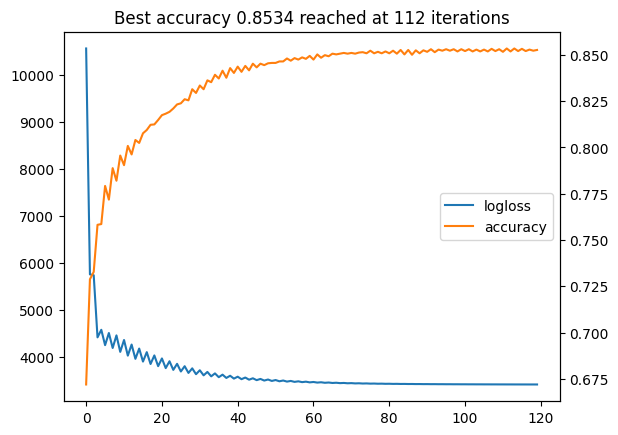

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import subprocess

parameters = f"2.5e-4,120,12000\n"
with open("params.csv", 'w') as f:
  lines = ['"Learning_rate","Number_iteration","Batch_size"\n', parameters]
  f.writelines(lines)
cmd_run = "./a.out"
run = subprocess.run(cmd_run, shell=True, capture_output=True)

data = pd.read_csv('log.txt',sep=',',header=None)
best_accuracy = np.max(data[1])
iteration = np.argmax(data[1]) + 1
fig,ax = plt.subplots()
l1 = ax.plot(data[0],label="logloss")
ax2=ax.twinx()
ax2.plot([], [])
l2 = ax2.plot(data[1],label="accuracy")

lines = l1 + l2
labels = [l.get_label() for l in lines]
ax.legend(lines, labels, loc=7)
ax.set_title(f"Best accuracy {best_accuracy} reached at {iteration} iterations")
plt.show()

## Batch gradient descent without normalisation

I also checked the results obtained without normalisation, to understand its effects on the algorithm.

In [ ]:
%%writefile linear_classification_wo_norm.cu

#include <stdio.h>
#include <stdlib.h>
#include <string.h>

#include <iostream>
#include <iomanip>
#include <math.h>
#include <time.h>
#include <fstream>

/*Matrix multiplication functions and other auxiliary functions*/
#include "fmatrix.cuh"
#include "read_csv.cuh"
#include "preprocess_data.cuh"
#include "classifier_math.cuh"
#include "evaluate_accuracy.cuh"
/* Includes, cuda */
#include <cuda_runtime.h>
#include <helper_cuda.h>

#include <unistd.h>

using namespace std;

//Number of thread per block
#define THREADS_PER_BLOCK 1024
/* Constants for housing data set */
#define data_columns  (9)
#define above_threshold (265000.0)

/////////////////////////////////////////////////////////
// Number of rows in arrays to print for debugging
/////////////////////////////////////////////////////////
#define print_rows (10)


/////////////////////////////////////////////////////////
// Main program
/////////////////////////////////////////////////////////
int main(int argc, char **argv)
{
    
    /////////////////////////////////////////////////////////
    // Parameters for the data set
    /////////////////////////////////////////////////////////
    size_t N_train = 12000; // points for training (Google: 12000) // default 4
    size_t N_test = 5000; // points for validation (Google: 5000) // default 2
    size_t N = N_train;
    size_t Nall = N_train+N_test;
    /////////////////////////////////////////////////////////
    // Reading the data set
    /////////////////////////////////////////////////////////
    fmatrix alldata = fmatrix_create_on_host(Nall,data_columns);
    read_csv("sample_data/california_housing_train.csv",alldata.data,Nall,data_columns);
    //fmatrix_print(alldata);

    size_t D = data_columns-1+1; // remove output column, add column with const. 1.0
    size_t M = 2; // number of labels (one-hot encoding)
    fmatrix Xall = fmatrix_create_on_host(D,Nall);
    fmatrix Yall = fmatrix_create_on_host(M,Nall);
    get_inputs_and_labels(alldata.data,&Xall.data,&Yall.data,Nall,data_columns,D,M);
    /////////////////////////////////////////////////////////
    // Inputs and labels are now available in X and Y.
    // Each input is a column in X; X is of dimension D x N
    // each label is a column in Y; Y is of dimension M x N
    /////////////////////////////////////////////////////////
     
    // Logfile
    FILE* fp = fopen("log.txt", "w");
    
    /////////////////////////////////////////////////////////
    // Parameters for Stochastic Gradient Descent
    /////////////////////////////////////////////////////////
    // Default values
    int nb_iter = 10;           // default: 10;
    int periods = nb_iter;      // reporting period
    int batch_size = N;         // default: N;
    float learning_rate = 1e-7; // default: 1e-7
    
    // Overwrites parameters with values from csv
    if (access("params.csv", F_OK) == 0) {
      fmatrix params = fmatrix_create_on_host(1, 3);
      read_csv("params.csv", params.data, 1, 3);
      nb_iter = getfm(params, 0, 1);
      periods = nb_iter;
      batch_size = getfm(params, 0, 2);
      learning_rate = getfm(params, 0, 0);
      fmatrix_free_on_host(&params);
    }

 
    /////////////////////////////////////////////////////////
    // Memory Allocation and Initialization
    /////////////////////////////////////////////////////////
    // take X,Y to be the first N columns of all data
    fmatrix h_X = fmatrix_subcolumns(Xall,0,N);
    fmatrix h_Y = fmatrix_subcolumns(Yall,0,N);
    fmatrix h_Xtest = fmatrix_subcolumns(Xall,N,Nall);
    fmatrix h_Ytest = fmatrix_subcolumns(Yall,N,Nall);
    fmatrix h_W = fmatrix_create_on_host(D,M);
    fmatrix h_J = fmatrix_create_on_host(1,1);

    /////////////////////////////////////////////////////////
    // Initializing Weight Matrix 
    // its dimension is D x M
    /////////////////////////////////////////////////////////
    xavier_weight_init(1.0,h_W);
 
    //////////////////////////////
    // Copy data to device      //
    //////////////////////////////
    fmatrix d_X = fmatrix_copy_to_device(h_X);
    fmatrix d_Y = fmatrix_copy_to_device(h_Y);
    fmatrix d_Xtest = fmatrix_copy_to_device(h_Xtest);
    fmatrix d_Ytest = fmatrix_copy_to_device(h_Ytest);
    fmatrix d_W = fmatrix_copy_to_device(h_W);
    fmatrix d_J = fmatrix_copy_to_device(h_J);

 
    /////////////////////////////////////////
    // Create auxiliary matrices on device //
    /////////////////////////////////////////
    fmatrix d_Z = fmatrix_create_on_device(M,batch_size);
    fmatrix d_P = fmatrix_create_on_device(M,batch_size);
    //fmatrix d_G = fmatrix_create_on_device(D,M);
    // auxiliary matrix for computing Z=W^T X on test data
    fmatrix d_Ztest = fmatrix_create_on_device(M,d_Xtest.cols);

    /////////////////////////////////////////////////////////
    // Batch Gradient Descent
    /////////////////////////////////////////////////////////
    //printf("Initial W after Xavier init:\n");
    //fmatrix_device_print(d_W);
 
     /* Evaluate the accuracy */
    float accuracy = 0;
    accuracy = evaluate_accuracy(d_W,d_Xtest,d_Ytest,d_Ztest);
    printf("initial accuracy: %f\n",accuracy);

    float J = 0;
 
    clock_t tstart_total, tend;
    tstart_total = clock();
 
    int batch_pointer = 0;
    for (int i = 0; i < nb_iter; ++i ) {

      ////////////////////////////////
      // compute Z = W^T X
      // --> each column z of Z corresponds to one column x of X
      ////////////////////////////////

      cublas_mult(1.0, CUBLAS_OP_T, CUBLAS_OP_N, d_W, d_X, 0.0, d_Z);

      ////////////////////////////////
      // For each column z of Z, compute activation p(z);
      // then update W
      ////////////////////////////////

      // compute softmax per column of Z and store in Z
      softmax_col(d_P, d_Z);

      // evaluate logloss (for reporting only)
      J = evaluate_logloss(d_P, d_Y);
      
      ////////////////////////////////
      // Q:=P-Y
      // compute gradient G = XQ^T
      // ... possibly work with G here ...
      // update weights W = W - learning_rate*G
      ////////////////////////////////

      // P = P - Y
      fmatrix_add(d_P, -1.0, d_Y);

      // W = W - learning_rate * (X. P^T) en une seule étape avec cuBLAS
      // alpha = -learning_rate, beta = 1
      cublas_mult(-1.0 * learning_rate, CUBLAS_OP_N, CUBLAS_OP_T, d_X, d_P, 1.0, d_W);

      ////////////////////////////////
      // For reporting, compute logloss and accuracy
      ////////////////////////////////
      if (i%(nb_iter/periods)==0) {
        float accuracy = evaluate_accuracy(d_W,d_Xtest,d_Ytest,d_Ztest);
        printf("iter: %d, logloss: %f, accuracy: %f\n", i, J, accuracy);
        fprintf(fp, "%f,%f\n", J, accuracy);
      }

    }
    tend = clock();
    float duration = ((float)(tend-tstart_total))/CLOCKS_PER_SEC;

    printf("final weights: \n");
    fmatrix_device_print(d_W);

    printf("Duration (s): %f\n",duration);

    /* Evaluate the accuracy */
    accuracy = evaluate_accuracy(d_W,d_Xtest,d_Ytest,d_Ztest);
    printf("final accuracy: %f\n",accuracy);

    /* Memory clean up */
    /** No need to free h_X, h_Y, h_Xtest, h_Ytest since 
     *  they all point to Xall 
     */
    fmatrix_free_on_host(&h_W);
    fmatrix_free_on_host(&Xall);
    fmatrix_free_on_host(&Yall);

    fmatrix_free_on_device(&d_X);
    fmatrix_free_on_device(&d_Y);
    fmatrix_free_on_device(&d_Xtest);
    fmatrix_free_on_device(&d_Ytest);
    fmatrix_free_on_device(&d_W);
    fmatrix_free_on_device(&d_Z);
    fmatrix_free_on_device(&d_J);
 
    // Close log file
    fclose(fp);
}

Overwriting linear_classification_wo_norm.cu


In [ ]:
!nvcc -arch=sm_35 -Wno-deprecated-gpu-targets -I cuda-samples/Common/ -L/usr/local/cuda/include -lcublas -lcusolver linear_classification_wo_norm.cu read_csv.cu preprocess_data.cu evaluate_accuracy.cu fmatrix.cu classifier_math.cu cuda_stuff.cu

linear_classification_wo_norm.cu(146): warning #177-D: variable "batch_pointer" was declared but never referenced



In [ ]:
!./a.out

headers: "longitude","latitude","housing_median_age","total_rooms","total_bedrooms","population","households","median_income","median_house_value"!
Read 17000 rows.
Allocated memory for inputs: 17000 rows, 9 columns.
Allocated memory for labels: 17000 rows, 2 columns.
Inputs (first 10):
1	1	1	1	1	1	1	1	1	1	
-114.31	-114.47	-114.56	-114.57	-114.57	-114.58	-114.58	-114.59	-114.59	-114.6	
34.19	34.4	33.69	33.64	33.57	33.63	33.61	34.83	33.61	34.83	
15	19	17	14	20	29	25	41	34	46	
5612	7650	720	1501	1454	1387	2907	812	4789	1497	
1283	1901	174	337	326	236	680	168	1175	309	
1015	1129	333	515	624	671	1841	375	3134	787	
472	463	117	226	262	239	633	158	1056	271	
1.4936	1.82	1.6509	3.1917	1.925	3.3438	2.6768	1.7083	2.1782	2.1908	
Labels (first 10):
0	0	0	0	0	0	0	0	0	0	
1	1	1	1	1	1	1	1	1	1	
initial accuracy: 0.660200
iter: 0, logloss: 220654.953125, accuracy: 0.340000
iter: 1, logloss: 824606.125000, accuracy: 0.660000
iter: 2, logloss: 223148.875000, accuracy: 0.660000
iter: 3, logloss: 223044.375

In [ ]:
from google.colab import data_table
import numpy as np
import pandas as pd
import subprocess
from tqdm.notebook import tqdm

rates = [1e-10, 1e-9, 5e-9, 1e-8, 5e-8, 1e-7, 5e-7, 1e-6, 5e-6, 1e-5, 5e-5, 1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 5e-2, 1e-1, 1, 1e1, 1e2, 1e3]
iterations = [500, 1000, 2500, 5000, 7500, 10000, 100000]

df = []
best_accuracy, best_lr, best_iter = 0, 0, 0
for lr in tqdm(rates):
  for iter in tqdm(iterations, leave=False):
    # Write hyperparameters to csv file
    parameters = f"{lr},{iter},12000\n"
    with open("params.csv", 'w') as f:
      lines = ['"Learning_rate","Number_iteration","Batch_size"\n', parameters]
      f.writelines(lines)
      
    # Run program, accessing the hyperparameters from the csv file
    cmd_run = "./a.out"
    run = subprocess.run(cmd_run, shell=True, capture_output=True)

    # Parse final accuracy for comparison
    final_accuracy = float(run.stdout.decode("utf-8").split("\n")[-2].split(": ")[-1])
      
    # Save values into list
    df.append([lr, iter, final_accuracy])
    if final_accuracy > best_accuracy:
      best_accuracy, best_lr, best_iter = final_accuracy, lr, iter
print(f"Best accuracy {best_accuracy} obtained for learning_rate {best_lr} and {best_iter} iterations.")
df = pd.DataFrame(df, columns=["Learning rate", "Number of iterations", "Final accuracy"])
data_table.DataTable(df, include_index=False, num_rows_per_page=26, min_width="30")

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Best accuracy 0.7428 obtained for learning_rate 0.0001 and 7500 iterations.


,Learning rate,Number of iterations,Final accuracy
0,1.000000e-10,500,0.5628
1,1.000000e-10,1000,0.5658
2,1.000000e-10,2500,0.5824
3,1.000000e-10,5000,0.5922
4,1.000000e-10,7500,0.5764
...,...,...,...
149,1.000000e+03,2500,0.5096
150,1.000000e+03,5000,0.6600
151,1.000000e+03,7500,0.6600
152,1.000000e+03,10000,0.5878


We can visualize the evolution of accuracy and logloss for a learning rate of $10^{-4}$ and 10000 iterations (we should notice a maximum around 7500 iterations according to the former table)

Final accuracy : 0.7148 - Duration : 4.073529 s


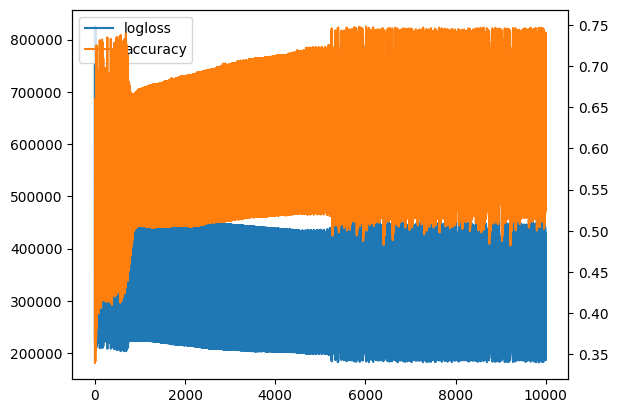

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import subprocess

parameters = f"1e-4,10000,12000\n"
with open("params.csv", 'w') as f:
  lines = ['"Learning_rate","Number_iteration","Batch_size"\n', parameters]
  f.writelines(lines)

cmd_run = "./a.out"
run = subprocess.run(cmd_run, shell=True, capture_output=True)
final_accuracy = float(run.stdout.decode("utf-8").split("\n")[-2].split(": ")[-1])
duration = float(run.stdout.decode("utf-8").split("\n")[-3].split(": ")[-1])
print(f"Final accuracy : {final_accuracy} - Duration : {duration} s")

data = pd.read_csv('log.txt',sep=',',header=None)
fig,ax = plt.subplots()
l1 = ax.plot(data[0],label="logloss")
ax2=ax.twinx()
ax2.plot([], [])
l2 = ax2.plot(data[1],label="accuracy")

lines = l1 + l2
labels = [l.get_label() for l in lines]
ax.legend(lines, labels, loc=2)
plt.show()

We notice that the computation time is fairly similar to the one when using normalized matrices. <br>
However, there are 3 major differences regarding the evolution of the accuracy and logloss :
* The learning is quite slower : it takes around 5000 iterations for the accuracy to stop increasing, while only around 100 were required for this learning rate with normalization
* The variance on the accuracy is quite important : range beteween 0.5 and 0.75 (quite important for logloss too)
* The best accuracy obtained is quite lower than the best accuracy with normalization for the same learning rate

For all these reasons, an optimal accuracy has not been further searched for batch gradient descent without matrix normalization.


## Mini batch gradient descent (with batch shuffling)

In [33]:
%%writefile mini_linear_classification.cu

#include <stdio.h>
#include <stdlib.h>
#include <string.h>

#include <iostream>
#include <iomanip>
#include <math.h>
#include <time.h>
#include <fstream>

/*Matrix multiplication functions and other auxiliary functions*/
#include "fmatrix.cuh"
#include "read_csv.cuh"
#include "preprocess_data.cuh"
#include "classifier_math.cuh"
#include "evaluate_accuracy.cuh"
/* Includes, cuda */
#include <cuda_runtime.h>
#include <helper_cuda.h>

#include <unistd.h>

using namespace std;

//Number of thread per block
#define THREADS_PER_BLOCK 1024
/* Constants for housing data set */
#define data_columns  (9)
#define above_threshold (265000.0)

/////////////////////////////////////////////////////////
// Number of rows in arrays to print for debugging
/////////////////////////////////////////////////////////
#define print_rows (10)


/////////////////////////////////////////////////////////
// Main program
/////////////////////////////////////////////////////////
int main(int argc, char **argv)
{
    
    /////////////////////////////////////////////////////////
    // Parameters for the data set
    /////////////////////////////////////////////////////////
    size_t N_train = 12000; // points for training (Google: 12000) // default 4
    size_t N_test = 5000; // points for validation (Google: 5000) // default 2
    size_t N = N_train;
    size_t Nall = N_train+N_test;
    /////////////////////////////////////////////////////////
    // Reading the data set
    /////////////////////////////////////////////////////////
    fmatrix alldata = fmatrix_create_on_host(Nall,data_columns);
    read_csv("sample_data/california_housing_train.csv",alldata.data,Nall,data_columns);
    //fmatrix_print(alldata);

    size_t D = data_columns-1+1; // remove output column, add column with const. 1.0
    size_t M = 2; // number of labels (one-hot encoding)
    fmatrix Xall = fmatrix_create_on_host(D,Nall);
    fmatrix Yall = fmatrix_create_on_host(M,Nall);
    get_inputs_and_labels(alldata.data,&Xall.data,&Yall.data,Nall,data_columns,D,M);
    /////////////////////////////////////////////////////////
    // Inputs and labels are now available in X and Y.
    // Each input is a column in X; X is of dimension D x N
    // each label is a column in Y; Y is of dimension M x N
    /////////////////////////////////////////////////////////
     
    // Logfile
    FILE* fp = fopen("log.txt", "w");
    
    /////////////////////////////////////////////////////////
    // Parameters for Stochastic Gradient Descent
    /////////////////////////////////////////////////////////
    // Default values
    int nb_iter = 10;           // default: 10;
    int periods = nb_iter;      // reporting period
    int batch_size = N;         // default: N;
    float learning_rate = 1e-7; // default: 1e-7
    int seed = 42;              // default: 42 - Seed for the random shuffle of mini batch
    
    // Overwrites parameters with values from csv
    if (access("params.csv", F_OK) == 0) {
      fmatrix params = fmatrix_create_on_host(1, 3);
      read_csv("params.csv", params.data, 1, 3);
      nb_iter = getfm(params, 0, 1);
      periods = nb_iter;
      batch_size = getfm(params, 0, 2);
      learning_rate = getfm(params, 0, 0);
      fmatrix_free_on_host(&params);
    }

 
    /////////////////////////////////////////////////////////
    // Memory Allocation and Initialization
    /////////////////////////////////////////////////////////
    // take X,Y to be the first N columns of all data
    fmatrix h_X = fmatrix_subcolumns(Xall,0,N);
    fmatrix h_Y = fmatrix_subcolumns(Yall,0,N);
    fmatrix h_Xtest = fmatrix_subcolumns(Xall,N,Nall);
    fmatrix h_Ytest = fmatrix_subcolumns(Yall,N,Nall);
    fmatrix h_W = fmatrix_create_on_host(D,M);
    fmatrix h_J = fmatrix_create_on_host(1,1);

    /////////////////////////////////////////////////////////
    // Initializing Weight Matrix 
    // its dimension is D x M
    /////////////////////////////////////////////////////////
    xavier_weight_init(1.0,h_W);
 
    //////////////////////////////
    // Copy data to device      //
    //////////////////////////////
    fmatrix d_X = fmatrix_copy_to_device(h_X);
    fmatrix d_Y = fmatrix_copy_to_device(h_Y);
    fmatrix d_Xtest = fmatrix_copy_to_device(h_Xtest);
    fmatrix d_Ytest = fmatrix_copy_to_device(h_Ytest);
    fmatrix d_W = fmatrix_copy_to_device(h_W);
    fmatrix d_J = fmatrix_copy_to_device(h_J);


    ////////////////////////////////////////////////////////////////
    // Normalize matrices X and X_test with mean and std of X     //
    ////////////////////////////////////////////////////////////////
    fmatrix *moments = compute_moments(d_X);
    normalize(d_X, moments[0], moments[1], 1);
    normalize(d_Xtest, moments[0], moments[1], 1);

 
    /////////////////////////////////////////
    // Create auxiliary matrices on device //
    /////////////////////////////////////////
    fmatrix d_Z = fmatrix_create_on_device(M,batch_size);
    fmatrix d_P = fmatrix_create_on_device(M,batch_size);
    //fmatrix d_G = fmatrix_create_on_device(D,M);
    // auxiliary matrix for computing Z=W^T X on test data
    fmatrix d_Ztest = fmatrix_create_on_device(M,d_Xtest.cols);

    /////////////////////////////////////////////////////////
    // Mini Batch Gradient Descent
    /////////////////////////////////////////////////////////
    //printf("Initial W after Xavier init:\n");
    //fmatrix_device_print(d_W);
 
     /* Evaluate the accuracy */
    float accuracy = 0;
    accuracy = evaluate_accuracy(d_W,d_Xtest,d_Ytest,d_Ztest);
    printf("initial accuracy: %f\n",accuracy);

    float J = 0;
 
    clock_t tstart_total, tend;
    tstart_total = clock();

    for (int i = 0; i < nb_iter; ++i ) {
      int batch_pointer = 0;
      // Shuffles matrices d_X and d_Y at each new epoch
      fmatrix_shuffle_col(d_X, d_Y, seed);

      fmatrix d_X_batch = fmatrix_create_on_device(d_X.rows, batch_size);
      fmatrix d_Y_batch = fmatrix_create_on_device(d_Y.rows, batch_size);

      while(batch_pointer < d_X.cols) {
        if (batch_pointer + batch_size <= d_X.cols) {
          // Update gradient for batch_size observations
          d_X_batch = fmatrix_subcolumns(d_X, batch_pointer, batch_pointer + batch_size);
          d_Y_batch = fmatrix_subcolumns(d_Y, batch_pointer, batch_pointer + batch_size);
          
          ////////////////////////////////
          // compute Z = W^T X
          // --> each column z of Z corresponds to one column x of X
          ////////////////////////////////

          cublas_mult(1.0, CUBLAS_OP_T, CUBLAS_OP_N, d_W, d_X_batch, 0.0, d_Z);

          ////////////////////////////////
          // For each column z of Z, compute activation p(z);
          // then update W
          ////////////////////////////////

          // compute softmax per column of Z and store in Z
          softmax_col(d_P, d_Z);

          // evaluate logloss (for reporting only)
          J = evaluate_logloss(d_P, d_Y_batch);
          
          ////////////////////////////////
          // Q:=P-Y
          // compute gradient G = XQ^T
          // ... possibly work with G here ...
          // update weights W = W - learning_rate*G
          ////////////////////////////////

          // P = P - Y
          fmatrix_add(d_P, -1.0, d_Y_batch);

          // W = W - learning_rate * (X. P^T) en une seule étape avec cuBLAS
          // alpha = -learning_rate, beta = 1
          cublas_mult(-1.0 * learning_rate, CUBLAS_OP_N, CUBLAS_OP_T, d_X_batch, d_P, 1.0, d_W);

        } else {
          // Compute gradient for ultimate batch if N is not a multiple of batch_size
          // N % batch_size : remainder of euclidean div of N by batch size = size of last batch
          fmatrix d_X_end = fmatrix_create_on_device(d_X.rows, N%batch_size);
          d_X_end = fmatrix_subcolumns(d_X, batch_pointer, d_X.cols);
          fmatrix d_Y_end = fmatrix_create_on_device(d_Y.rows, N%batch_size);
          d_Y_end = fmatrix_subcolumns(d_Y, batch_pointer, d_Y.cols);
          fmatrix d_Z_end = fmatrix_create_on_device(M, N%batch_size);
          fmatrix d_P_end = fmatrix_create_on_device(M, N%batch_size);

          ////////////////////////////////
          // compute Z = W^T X
          // --> each column z of Z corresponds to one column x of X
          ////////////////////////////////

          cublas_mult(1.0, CUBLAS_OP_T, CUBLAS_OP_N, d_W, d_X_end, 0.0, d_Z_end);

          ////////////////////////////////
          // For each column z of Z, compute activation p(z);
          // then update W
          ////////////////////////////////

          // compute softmax per column of Z and store in Z
          softmax_col(d_P_end, d_Z_end);

          // evaluate logloss (for reporting only)
          J = evaluate_logloss(d_P_end, d_Y_end);
          
          ////////////////////////////////
          // Q:=P-Y
          // compute gradient G = XQ^T
          // ... possibly work with G here ...
          // update weights W = W - learning_rate*G
          ////////////////////////////////

          // P = P - Y
          fmatrix_add(d_P_end, -1.0, d_Y_end);

          // W = W - learning_rate * (X. P^T) en une seule étape avec cuBLAS
          // alpha = -learning_rate, beta = 1
          cublas_mult(-1.0 * learning_rate, CUBLAS_OP_N, CUBLAS_OP_T, d_X_end, d_P_end, 1.0, d_W);
        }

        batch_pointer += batch_size;

      }
      
      ////////////////////////////////
      // For reporting, compute logloss and accuracy at each epoch
      ////////////////////////////////
      if (i%(nb_iter/periods)==0) {
        float accuracy = evaluate_accuracy(d_W,d_Xtest,d_Ytest,d_Ztest);
        printf("iter: %d, logloss: %f, accuracy: %f\n", i, J, accuracy);
        fprintf(fp, "%f,%f\n", J, accuracy);
      }

    }
    tend = clock();
    float duration = ((float)(tend-tstart_total))/CLOCKS_PER_SEC;

    printf("final weights: \n");
    fmatrix_device_print(d_W);

    printf("Duration (s): %f\n",duration);

    /* Evaluate the accuracy */
    accuracy = evaluate_accuracy(d_W,d_Xtest,d_Ytest,d_Ztest);
    printf("final accuracy: %f\n",accuracy);

    /* Memory clean up */
    /** No need to free h_X, h_Y, h_Xtest, h_Ytest since 
     *  they all point to Xall 
     */
    fmatrix_free_on_host(&h_W);
    fmatrix_free_on_host(&Xall);
    fmatrix_free_on_host(&Yall);

    fmatrix_free_on_device(&d_X);
    fmatrix_free_on_device(&d_Y);
    fmatrix_free_on_device(&d_Xtest);
    fmatrix_free_on_device(&d_Ytest);
    fmatrix_free_on_device(&d_W);
    fmatrix_free_on_device(&d_Z);
    fmatrix_free_on_device(&d_J);
 
    // Close log file
    fclose(fp);
}

Overwriting mini_linear_classification.cu


In [34]:
!nvcc -arch=sm_35 -Wno-deprecated-gpu-targets -I cuda-samples/Common/ -L/usr/local/cuda/include -lcublas -lcusolver mini_linear_classification.cu read_csv.cu preprocess_data.cu evaluate_accuracy.cu fmatrix.cu classifier_math.cu cuda_stuff.cu -o mini_batch.out

<u>Naive test of the program on the whole dataset with default values</u>

In [ ]:
!./mini_batch.out

headers: "longitude","latitude","housing_median_age","total_rooms","total_bedrooms","population","households","median_income","median_house_value"!
Read 17000 rows.
Allocated memory for inputs: 17000 rows, 9 columns.
Allocated memory for labels: 17000 rows, 2 columns.
Inputs (first 10):
1	1	1	1	1	1	1	1	1	1	
-114.31	-114.47	-114.56	-114.57	-114.57	-114.58	-114.58	-114.59	-114.59	-114.6	
34.19	34.4	33.69	33.64	33.57	33.63	33.61	34.83	33.61	34.83	
15	19	17	14	20	29	25	41	34	46	
5612	7650	720	1501	1454	1387	2907	812	4789	1497	
1283	1901	174	337	326	236	680	168	1175	309	
1015	1129	333	515	624	671	1841	375	3134	787	
472	463	117	226	262	239	633	158	1056	271	
1.4936	1.82	1.6509	3.1917	1.925	3.3438	2.6768	1.7083	2.1782	2.1908	
Labels (first 10):
0	0	0	0	0	0	0	0	0	0	
1	1	1	1	1	1	1	1	1	1	
initial accuracy: 0.340200
iter: 0, logloss: 10563.833008, accuracy: 0.340200
iter: 1, logloss: 10556.374023, accuracy: 0.340200
iter: 2, logloss: 10548.945312, accuracy: 0.340200
iter: 3, logloss: 10541.502930,

We observe the same kind of results as with the batch gradient descent (which is logical since default value for batch_size = N).

In [ ]:
from google.colab import data_table
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import subprocess
from tqdm.notebook import tqdm

rates = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3]
iterations = [10, 100, 200, 500, 1000, 10000]
batches = [32, 64, 128, 256, 512, 1024, 2048]


df = []
best_accuracy, best_lr, best_iter, best_bs = 0, 0, 0, 0
for lr in tqdm(rates):
  for iter in tqdm(iterations, leave=False):
    for bs in tqdm(batches, leave=False):
      # Write hyperparameters to csv file
      parameters = f"{lr},{iter},{bs}\n"
      with open("params.csv", 'w') as f:
        lines = ['"Learning_rate","Number_iteration","Batch_size"\n', parameters]
        f.writelines(lines)
        
      # Run program, accessing the hyperparameters from the csv file
      cmd_run = "./mini_batch.out"
      run = subprocess.run(cmd_run, shell=True, capture_output=True)

      # Parse final accuracy for comparison
      final_accuracy = float(run.stdout.decode("utf-8").split("\n")[-2].split(": ")[-1])
      duration = float(run.stdout.decode("utf-8").split("\n")[-3].split(": ")[-1])
        
      # Save values into list
      df.append([lr, iter, bs, final_accuracy, duration])
      if final_accuracy > best_accuracy:
        best_accuracy, best_lr, best_iter, best_bs = final_accuracy, lr, iter, bs
print(f"Best accuracy {best_accuracy} obtained for learning_rate {best_lr}, {best_iter} iterations and batch size of {best_bs}.")
df = pd.DataFrame(df, columns=["Learning rate", "Number of iterations", "Batch Size", "Final accuracy", "Duration"])
data_table.DataTable(df, include_index=False, num_rows_per_page=50, min_width="30")

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Best accuracy 0.8616 obtained for learning_rate 10.0, 1000 iterations and batch size of 125.


,Learning rate,Number of iterations,Batch Size,Final accuracy,Duration
0,1.000000e-07,10,32,0.3400,0.335753
1,1.000000e-07,10,64,0.3400,0.171749
2,1.000000e-07,10,125,0.3400,0.094492
3,1.000000e-07,10,256,0.3400,0.054426
4,1.000000e-07,10,512,0.3400,0.033682
...,...,...,...,...,...
457,1.000000e+03,10000,125,0.7928,81.612358
458,1.000000e+03,10000,256,0.8474,43.777279
459,1.000000e+03,10000,512,0.8146,27.130199
460,1.000000e+03,10000,1024,0.8452,18.869579


Several interesting observations can be made from these results :
* The batch size does not have any impact on the accuracy for low learning rates (learning rate < 0.01). However, it has a drastic impact on the computation time (which was to be expected)
* For low learning rate, the accuracy seem to increase smoothly, despite the shuffling in the batch
* An accuracy score slightly better than the one obtained with batch gradient descent has been reached with a much higher learning rate (accuracy > 0.86 for learning rates of 10 and 1000). Due to the increased stochasticity, the mini batch gradient descent is supposed to be able to escape local minima and potentially reach better scores, which explains the results. Plotting the accuracy and logloss curves might bring more information about the behaviour of the evolution of the accuracy for such high learning rates.

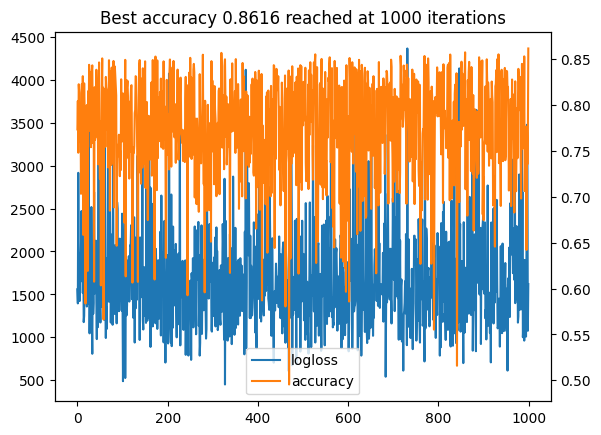

In [ ]:
parameters = f"10,1000,125\n"
with open("params.csv", 'w') as f:
  lines = ['"Learning_rate","Number_iteration","Batch_size"\n', parameters]
  f.writelines(lines)
cmd_run = "./mini_batch.out"
run = subprocess.run(cmd_run, shell=True, capture_output=True)

data = pd.read_csv('log.txt',sep=',',header=None)
best_accuracy = np.max(data[1])
iteration = np.argmax(data[1]) + 1
fig,ax = plt.subplots()
l1 = ax.plot(data[0],label="logloss")
ax2=ax.twinx()
ax2.plot([], [])
l2 = ax2.plot(data[1],label="accuracy")

lines = l1 + l2
labels = [l.get_label() for l in lines]
ax.legend(lines, labels, loc=8)
ax.set_title(f"Best accuracy {best_accuracy} reached at {iteration} iterations")
plt.show()

As could be expected, the best accuracy obtained is juste due to noisy variations around a gradient minimum, and does not to actual learning. <br>
Let's have a look at the curves obtained for a learning rate of $10^{-4}$, which gave the best results for batch gradient descent.

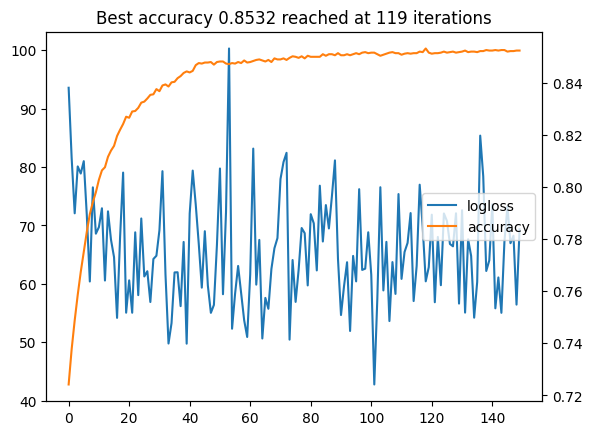

In [ ]:
parameters = f"2.5e-4,150,512\n"
with open("params.csv", 'w') as f:
  lines = ['"Learning_rate","Number_iteration","Batch_size"\n', parameters]
  f.writelines(lines)
cmd_run = "./mini_batch.out"
run = subprocess.run(cmd_run, shell=True, capture_output=True)

data = pd.read_csv('log.txt',sep=',',header=None)
best_accuracy = np.max(data[1])
iteration = np.argmax(data[1]) + 1
fig,ax = plt.subplots()
l1 = ax.plot(data[0],label="logloss")
ax2=ax.twinx()
ax2.plot([], [])
l2 = ax2.plot(data[1],label="accuracy")

lines = l1 + l2
labels = [l.get_label() for l in lines]
ax.legend(lines, labels, loc=7)
ax.set_title(f"Best accuracy {best_accuracy} reached at {iteration} iterations")
plt.show()

The accuracy curve here is much smoother. The logloss seems a bit chaotic, but its value only vary between ~95 and 50 (to be compared with values between 3000 and 1000 for batch gradient descent). <br>
The results are thus much cleaner with mini batch gradient descent, but the best accuracy remain in the same order (0.0002 lower) <br>
Learning rate of $10^{-3}$ also seems to give good results.

In [ ]:
parameters = f"1.5e-3,241,2048\n"
with open("params.csv", 'w') as f:
  lines = ['"Learning_rate","Number_iteration","Batch_size"\n', parameters]
  f.writelines(lines)
acc, avg_dur = [], []
for _ in tqdm(range(50)):
  cmd_run = "./mini_batch.out"
  run = subprocess.run(cmd_run, shell=True, capture_output=True)
  acc.append(float(run.stdout.decode("utf-8").split("\n")[-2].split(": ")[-1]))
  avg_dur.append(float(run.stdout.decode("utf-8").split("\n")[-3].split(": ")[-1]))
print(f"Average accuracy {np.mean(acc)} - Average computation time {np.mean(avg_dur)}s.")

  0%|          | 0/50 [00:00<?, ?it/s]

Average accuracy 0.8596 - Average computation time 0.35562511999999996s.


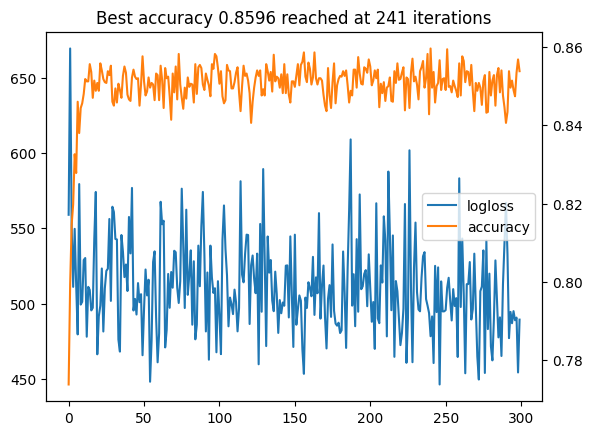

In [ ]:
parameters = f"1.5e-3,300,2048\n"
with open("params.csv", 'w') as f:
  lines = ['"Learning_rate","Number_iteration","Batch_size"\n', parameters]
  f.writelines(lines)
cmd_run = "./mini_batch.out"
run = subprocess.run(cmd_run, shell=True, capture_output=True)

data = pd.read_csv('log.txt',sep=',',header=None)
best_accuracy = np.max(data[1])
iteration = np.argmax(data[1]) + 1
fig,ax = plt.subplots()
l1 = ax.plot(data[0],label="logloss")
ax2=ax.twinx()
ax2.plot([], [])
l2 = ax2.plot(data[1],label="accuracy")

lines = l1 + l2
labels = [l.get_label() for l in lines]
ax.legend(lines, labels, loc=7)
ax.set_title(f"Best accuracy {best_accuracy} reached at {iteration} iterations")
plt.show()

The results are noisier than for a learning rate of  $10^{-4}$, but still rather clean in comparison to the learning rate of 10. <br>
Thus, the combination of the following parameters seems to be a good compromise to reach an accuracy of **0.8596**:
* Learning rate 1.5e-3
* Number of iterations = 241
* Average computation time = 0.356 s (over 50 runs)

## Mini batch gradient descent (without batch shuffling)

Mini study of the impact of shuffling the data in the batch at each iteration <br>
The program is ran witouth shufflong on a smaller range of hyperparameters to see if it really has an impact (apart from increasing the computation time)

In [31]:
%%writefile mini_linear_classification_noshuffle.cu

#include <stdio.h>
#include <stdlib.h>
#include <string.h>

#include <iostream>
#include <iomanip>
#include <math.h>
#include <time.h>
#include <fstream>

/*Matrix multiplication functions and other auxiliary functions*/
#include "fmatrix.cuh"
#include "read_csv.cuh"
#include "preprocess_data.cuh"
#include "classifier_math.cuh"
#include "evaluate_accuracy.cuh"
/* Includes, cuda */
#include <cuda_runtime.h>
#include <helper_cuda.h>

#include <unistd.h>

using namespace std;

//Number of thread per block
#define THREADS_PER_BLOCK 1024
/* Constants for housing data set */
#define data_columns  (9)
#define above_threshold (265000.0)

/////////////////////////////////////////////////////////
// Number of rows in arrays to print for debugging
/////////////////////////////////////////////////////////
#define print_rows (10)


/////////////////////////////////////////////////////////
// Main program
/////////////////////////////////////////////////////////
int main(int argc, char **argv)
{
    
    /////////////////////////////////////////////////////////
    // Parameters for the data set
    /////////////////////////////////////////////////////////
    size_t N_train = 12000; // points for training (Google: 12000) // default 4
    size_t N_test = 5000; // points for validation (Google: 5000) // default 2
    size_t N = N_train;
    size_t Nall = N_train+N_test;
    /////////////////////////////////////////////////////////
    // Reading the data set
    /////////////////////////////////////////////////////////
    fmatrix alldata = fmatrix_create_on_host(Nall,data_columns);
    read_csv("sample_data/california_housing_train.csv",alldata.data,Nall,data_columns);
    //fmatrix_print(alldata);

    size_t D = data_columns-1+1; // remove output column, add column with const. 1.0
    size_t M = 2; // number of labels (one-hot encoding)
    fmatrix Xall = fmatrix_create_on_host(D,Nall);
    fmatrix Yall = fmatrix_create_on_host(M,Nall);
    get_inputs_and_labels(alldata.data,&Xall.data,&Yall.data,Nall,data_columns,D,M);
    /////////////////////////////////////////////////////////
    // Inputs and labels are now available in X and Y.
    // Each input is a column in X; X is of dimension D x N
    // each label is a column in Y; Y is of dimension M x N
    /////////////////////////////////////////////////////////
     
    // Logfile
    FILE* fp = fopen("log.txt", "w");
    
    /////////////////////////////////////////////////////////
    // Parameters for Stochastic Gradient Descent
    /////////////////////////////////////////////////////////
    // Default values
    int nb_iter = 10;           // default: 10;
    int periods = nb_iter;      // reporting period
    int batch_size = N;         // default: N;
    float learning_rate = 1e-7; // default: 1e-7
    
    // Overwrites parameters with values from csv
    if (access("params.csv", F_OK) == 0) {
      fmatrix params = fmatrix_create_on_host(1, 3);
      read_csv("params.csv", params.data, 1, 3);
      nb_iter = getfm(params, 0, 1);
      periods = nb_iter;
      batch_size = getfm(params, 0, 2);
      learning_rate = getfm(params, 0, 0);
      fmatrix_free_on_host(&params);
    }

 
    /////////////////////////////////////////////////////////
    // Memory Allocation and Initialization
    /////////////////////////////////////////////////////////
    // take X,Y to be the first N columns of all data
    fmatrix h_X = fmatrix_subcolumns(Xall,0,N);
    fmatrix h_Y = fmatrix_subcolumns(Yall,0,N);
    fmatrix h_Xtest = fmatrix_subcolumns(Xall,N,Nall);
    fmatrix h_Ytest = fmatrix_subcolumns(Yall,N,Nall);
    fmatrix h_W = fmatrix_create_on_host(D,M);
    fmatrix h_J = fmatrix_create_on_host(1,1);

    /////////////////////////////////////////////////////////
    // Initializing Weight Matrix 
    // its dimension is D x M
    /////////////////////////////////////////////////////////
    xavier_weight_init(1.0,h_W);
 
    //////////////////////////////
    // Copy data to device      //
    //////////////////////////////
    fmatrix d_X = fmatrix_copy_to_device(h_X);
    fmatrix d_Y = fmatrix_copy_to_device(h_Y);
    fmatrix d_Xtest = fmatrix_copy_to_device(h_Xtest);
    fmatrix d_Ytest = fmatrix_copy_to_device(h_Ytest);
    fmatrix d_W = fmatrix_copy_to_device(h_W);
    fmatrix d_J = fmatrix_copy_to_device(h_J);


    ////////////////////////////////////////////////////////////////
    // Normalize matrices X and X_test with mean and std of X     //
    ////////////////////////////////////////////////////////////////
    fmatrix *moments = compute_moments(d_X);
    normalize(d_X, moments[0], moments[1], 1);
    normalize(d_Xtest, moments[0], moments[1], 1);

 
    /////////////////////////////////////////
    // Create auxiliary matrices on device //
    /////////////////////////////////////////
    fmatrix d_Z = fmatrix_create_on_device(M,batch_size);
    fmatrix d_P = fmatrix_create_on_device(M,batch_size);
    //fmatrix d_G = fmatrix_create_on_device(D,M);
    // auxiliary matrix for computing Z=W^T X on test data
    fmatrix d_Ztest = fmatrix_create_on_device(M,d_Xtest.cols);

    /////////////////////////////////////////////////////////
    // Mini Batch Gradient Descent
    /////////////////////////////////////////////////////////
    //printf("Initial W after Xavier init:\n");
    //fmatrix_device_print(d_W);
 
     /* Evaluate the accuracy */
    float accuracy = 0;
    accuracy = evaluate_accuracy(d_W,d_Xtest,d_Ytest,d_Ztest);
    printf("initial accuracy: %f\n",accuracy);

    float J = 0;
 
    clock_t tstart_total, tend;
    tstart_total = clock();

    for (int i = 0; i < nb_iter; ++i ) {
      int batch_pointer = 0;

      fmatrix d_X_batch = fmatrix_create_on_device(d_X.rows, batch_size);
      fmatrix d_Y_batch = fmatrix_create_on_device(d_Y.rows, batch_size);

      while(batch_pointer < d_X.cols) {
        if (batch_pointer + batch_size <= d_X.cols) {
          // Update gradient for batch_size observations
          d_X_batch = fmatrix_subcolumns(d_X, batch_pointer, batch_pointer + batch_size);
          d_Y_batch = fmatrix_subcolumns(d_Y, batch_pointer, batch_pointer + batch_size);
          
          ////////////////////////////////
          // compute Z = W^T X
          // --> each column z of Z corresponds to one column x of X
          ////////////////////////////////

          cublas_mult(1.0, CUBLAS_OP_T, CUBLAS_OP_N, d_W, d_X_batch, 0.0, d_Z);

          ////////////////////////////////
          // For each column z of Z, compute activation p(z);
          // then update W
          ////////////////////////////////

          // compute softmax per column of Z and store in Z
          softmax_col(d_P, d_Z);

          // evaluate logloss (for reporting only)
          J = evaluate_logloss(d_P, d_Y_batch);
          
          ////////////////////////////////
          // Q:=P-Y
          // compute gradient G = XQ^T
          // ... possibly work with G here ...
          // update weights W = W - learning_rate*G
          ////////////////////////////////

          // P = P - Y
          fmatrix_add(d_P, -1.0, d_Y_batch);

          // W = W - learning_rate * (X. P^T) en une seule étape avec cuBLAS
          // alpha = -learning_rate, beta = 1
          cublas_mult(-1.0 * learning_rate, CUBLAS_OP_N, CUBLAS_OP_T, d_X_batch, d_P, 1.0, d_W);

        } else {
          // Compute gradient for ultimate batch if N is not a multiple of batch_size
          // N % batch_size : remainder of euclidean div of N by batch size = size of last batch
          fmatrix d_X_end = fmatrix_create_on_device(d_X.rows, N%batch_size);
          d_X_end = fmatrix_subcolumns(d_X, batch_pointer, d_X.cols);
          fmatrix d_Y_end = fmatrix_create_on_device(d_Y.rows, N%batch_size);
          d_Y_end = fmatrix_subcolumns(d_Y, batch_pointer, d_Y.cols);
          fmatrix d_Z_end = fmatrix_create_on_device(M, N%batch_size);
          fmatrix d_P_end = fmatrix_create_on_device(M, N%batch_size);

          ////////////////////////////////
          // compute Z = W^T X
          // --> each column z of Z corresponds to one column x of X
          ////////////////////////////////

          cublas_mult(1.0, CUBLAS_OP_T, CUBLAS_OP_N, d_W, d_X_end, 0.0, d_Z_end);

          ////////////////////////////////
          // For each column z of Z, compute activation p(z);
          // then update W
          ////////////////////////////////

          // compute softmax per column of Z and store in Z
          softmax_col(d_P_end, d_Z_end);

          // evaluate logloss (for reporting only)
          J = evaluate_logloss(d_P_end, d_Y_end);
          
          ////////////////////////////////
          // Q:=P-Y
          // compute gradient G = XQ^T
          // ... possibly work with G here ...
          // update weights W = W - learning_rate*G
          ////////////////////////////////

          // P = P - Y
          fmatrix_add(d_P_end, -1.0, d_Y_end);

          // W = W - learning_rate * (X. P^T) en une seule étape avec cuBLAS
          // alpha = -learning_rate, beta = 1
          cublas_mult(-1.0 * learning_rate, CUBLAS_OP_N, CUBLAS_OP_T, d_X_end, d_P_end, 1.0, d_W);
        }

        batch_pointer += batch_size;

      }
      
      ////////////////////////////////
      // For reporting, compute logloss and accuracy at each epoch
      ////////////////////////////////
      if (i%(nb_iter/periods)==0) {
        float accuracy = evaluate_accuracy(d_W,d_Xtest,d_Ytest,d_Ztest);
        printf("iter: %d, logloss: %f, accuracy: %f\n", i, J, accuracy);
        fprintf(fp, "%f,%f\n", J, accuracy);
      }

    }
    tend = clock();
    float duration = ((float)(tend-tstart_total))/CLOCKS_PER_SEC;

    printf("final weights: \n");
    fmatrix_device_print(d_W);

    printf("Duration (s): %f\n",duration);

    /* Evaluate the accuracy */
    accuracy = evaluate_accuracy(d_W,d_Xtest,d_Ytest,d_Ztest);
    printf("final accuracy: %f\n",accuracy);

    /* Memory clean up */
    /** No need to free h_X, h_Y, h_Xtest, h_Ytest since 
     *  they all point to Xall 
     */
    fmatrix_free_on_host(&h_W);
    fmatrix_free_on_host(&Xall);
    fmatrix_free_on_host(&Yall);

    fmatrix_free_on_device(&d_X);
    fmatrix_free_on_device(&d_Y);
    fmatrix_free_on_device(&d_Xtest);
    fmatrix_free_on_device(&d_Ytest);
    fmatrix_free_on_device(&d_W);
    fmatrix_free_on_device(&d_Z);
    fmatrix_free_on_device(&d_J);
 
    // Close log file
    fclose(fp);
}

Overwriting mini_linear_classification_noshuffle.cu


In [32]:
!nvcc -arch=sm_35 -Wno-deprecated-gpu-targets -I cuda-samples/Common/ -L/usr/local/cuda/include -lcublas -lcusolver mini_linear_classification_noshuffle.cu read_csv.cu preprocess_data.cu evaluate_accuracy.cu fmatrix.cu classifier_math.cu cuda_stuff.cu -o mini_batch_noshuffle.out

In [ ]:
from google.colab import data_table
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import subprocess
from tqdm.notebook import tqdm

rates = [1e-5, 1e-4, 1e-3, 1e-2]
iterations = [10, 100, 200, 500, 1000]
batches = [128, 256, 512, 1024, 2048]


df = []
best_accuracy, best_lr, best_iter, best_bs = 0, 0, 0, 0
for lr in tqdm(rates):
  for iter in tqdm(iterations, leave=False):
    for bs in tqdm(batches, leave=False):
      # Write hyperparameters to csv file
      parameters = f"{lr},{iter},{bs}\n"
      with open("params.csv", 'w') as f:
        lines = ['"Learning_rate","Number_iteration","Batch_size"\n', parameters]
        f.writelines(lines)
        
      # Run program, accessing the hyperparameters from the csv file
      cmd_run = "./mini_batch_noshuffle.out"
      run = subprocess.run(cmd_run, shell=True, capture_output=True)

      # Parse final accuracy for comparison
      accuracy_ns = float(run.stdout.decode("utf-8").split("\n")[-2].split(": ")[-1])
      duration = float(run.stdout.decode("utf-8").split("\n")[-3].split(": ")[-1])

      cmd_run = "./mini_batch.out"
      run = subprocess.run(cmd_run, shell=True, capture_output=True)
      accuracy_shuffle = float(run.stdout.decode("utf-8").split("\n")[-2].split(": ")[-1])
        
      # Save values into list
      df.append([lr, iter, bs, duration, accuracy_ns, accuracy_shuffle])
      if final_accuracy > best_accuracy:
        best_accuracy, best_lr, best_iter, best_bs = final_accuracy, lr, iter, bs
print(f"Best accuracy {best_accuracy} obtained for learning_rate {best_lr}, {best_iter} iterations and batch size of {best_bs}.")
df = pd.DataFrame(df, columns=["Learning rate", "Number of iterations", "Batch Size", "Duration", "Accuracy w/o shuffle", "Accuracy with shuffle"])
data_table.DataTable(df, include_index=False, num_rows_per_page=25, min_width="30")

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Best accuracy 0.8466 obtained for learning_rate 1e-05, 10 iterations and batch size of 128.


,Learning rate,Number of iterations,Batch Size,Duration,Accuracy w/o shuffle,Accuracy with shuffle
0,0.00001,10,128,0.084694,0.7452,0.7450
1,0.00001,10,256,0.045980,0.7452,0.7450
2,0.00001,10,512,0.027440,0.7452,0.7450
3,0.00001,10,1024,0.013706,0.7448,0.7446
4,0.00001,10,2048,0.008359,0.7436,0.7444
...,...,...,...,...,...,...
95,0.01000,1000,128,7.312142,0.8330,0.8498
96,0.01000,1000,256,3.391519,0.8264,0.8386
97,0.01000,1000,512,2.208830,0.8550,0.8292
98,0.01000,1000,1024,1.084647,0.8440,0.8304


The results obtained are a bit lower than the ones obtained with shuffling for learning rates under $10^{-2}$. The results depend on the number of the other parameters for learning rate of 0.01, let's have a look at the curves.

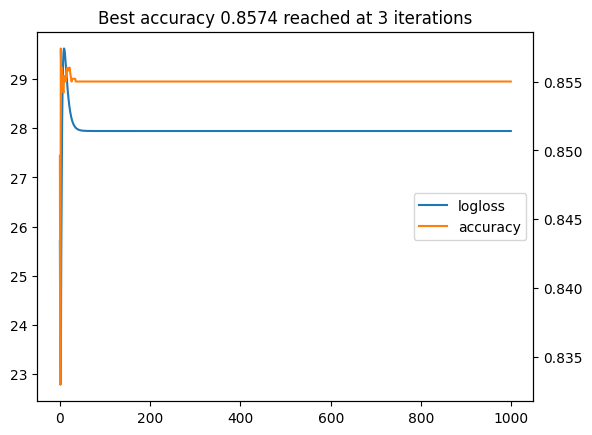

In [ ]:
parameters = f"0.01,1000,512\n"
with open("params.csv", 'w') as f:
  lines = ['"Learning_rate","Number_iteration","Batch_size"\n', parameters]
  f.writelines(lines)
cmd_run = "./mini_batch_noshuffle.out"
run = subprocess.run(cmd_run, shell=True, capture_output=True)

data = pd.read_csv('log.txt',sep=',',header=None)
best_accuracy = np.max(data[1])
iteration = np.argmax(data[1]) + 1
fig,ax = plt.subplots()
l1 = ax.plot(data[0],label="logloss")
ax2=ax.twinx()
ax2.plot([], [])
l2 = ax2.plot(data[1],label="accuracy")

lines = l1 + l2
labels = [l.get_label() for l in lines]
ax.legend(lines, labels, loc=7)
ax.set_title(f"Best accuracy {best_accuracy} reached at {iteration} iterations")
plt.show()

The results are actually really clean ! Only 3 iterations are required to reach the best score, which should also beat all other computation times. However, the accuracy seems to diverge from the maximum and converge towards 0.8555 at around 40 iterations (zoom below)

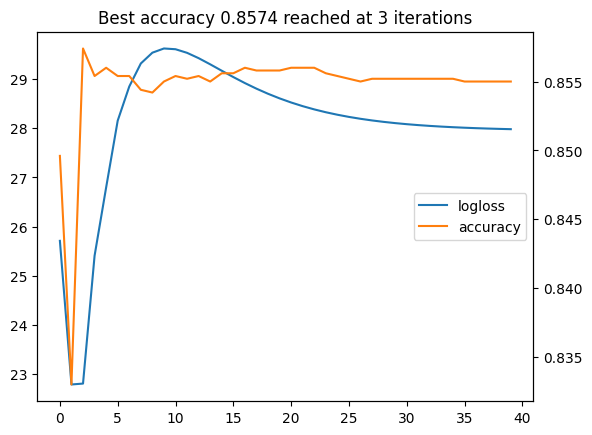

In [ ]:
parameters = f"0.01,40,512\n"
with open("params.csv", 'w') as f:
  lines = ['"Learning_rate","Number_iteration","Batch_size"\n', parameters]
  f.writelines(lines)
cmd_run = "./mini_batch_noshuffle.out"
run = subprocess.run(cmd_run, shell=True, capture_output=True)

data = pd.read_csv('log.txt',sep=',',header=None)
best_accuracy = np.max(data[1])
iteration = np.argmax(data[1]) + 1
fig,ax = plt.subplots()
l1 = ax.plot(data[0],label="logloss")
ax2=ax.twinx()
ax2.plot([], [])
l2 = ax2.plot(data[1],label="accuracy")

lines = l1 + l2
labels = [l.get_label() for l in lines]
ax.legend(lines, labels, loc=7)
ax.set_title(f"Best accuracy {best_accuracy} reached at {iteration} iterations")
plt.show()

In [ ]:
parameters = f"0.01,40,512\n"
with open("params.csv", 'w') as f:
  lines = ['"Learning_rate","Number_iteration","Batch_size"\n', parameters]
  f.writelines(lines)
acc, avg_dur = [], []
for _ in tqdm(range(50)):
  cmd_run = "./mini_batch_noshuffle.out"
  run = subprocess.run(cmd_run, shell=True, capture_output=True)
  acc.append(float(run.stdout.decode("utf-8").split("\n")[-2].split(": ")[-1]))
  avg_dur.append(float(run.stdout.decode("utf-8").split("\n")[-3].split(": ")[-1]))
print(f"Average accuracy {np.mean(acc)} - Average computation time {np.mean(avg_dur)}s.")

  0%|          | 0/50 [00:00<?, ?it/s]

Average accuracy 0.855 - Average computation time 0.11229758000000002s.


In [ ]:
parameters = f"0.01,3,512\n"
with open("params.csv", 'w') as f:
  lines = ['"Learning_rate","Number_iteration","Batch_size"\n', parameters]
  f.writelines(lines)
acc, avg_dur = [], []
for _ in tqdm(range(50)):
  cmd_run = "./mini_batch_noshuffle.out"
  run = subprocess.run(cmd_run, shell=True, capture_output=True)
  acc.append(float(run.stdout.decode("utf-8").split("\n")[-2].split(": ")[-1]))
  avg_dur.append(float(run.stdout.decode("utf-8").split("\n")[-3].split(": ")[-1]))
print(f"Average accuracy {np.mean(acc)} - Average computation time {np.mean(avg_dur)}s.")

  0%|          | 0/50 [00:00<?, ?it/s]

Average accuracy 0.8573999999999999 - Average computation time 0.00849816s.


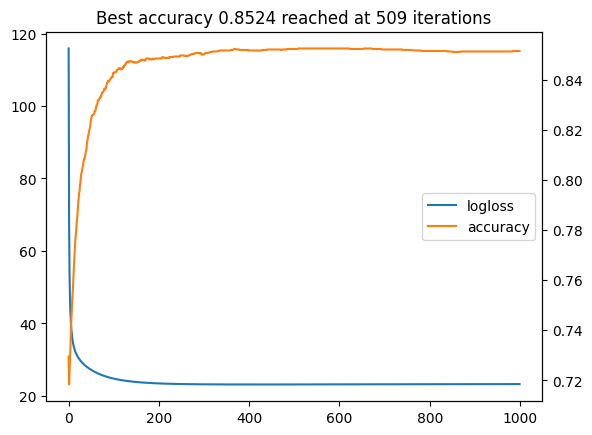

In [ ]:
parameters = f"1e-4,1000,512\n"
with open("params.csv", 'w') as f:
  lines = ['"Learning_rate","Number_iteration","Batch_size"\n', parameters]
  f.writelines(lines)
cmd_run = "./mini_batch_noshuffle.out"
run = subprocess.run(cmd_run, shell=True, capture_output=True)

data = pd.read_csv('log.txt',sep=',',header=None)
best_accuracy = np.max(data[1])
iteration = np.argmax(data[1]) + 1
fig,ax = plt.subplots()
l1 = ax.plot(data[0],label="logloss")
ax2=ax.twinx()
ax2.plot([], [])
l2 = ax2.plot(data[1],label="accuracy")

lines = l1 + l2
labels = [l.get_label() for l in lines]
ax.legend(lines, labels, loc=7)
ax.set_title(f"Best accuracy {best_accuracy} reached at {iteration} iterations")
plt.show()

It seems shuffing the batches is not always the best solution. But it should be kept in mind that my shuffling implementation is far from perfect (both in terms of randomness and in terms of computational efficiency), and that the seed is set to 42 (other seeds may bring different results).

# Conclusion

Either with batch gradient or mini-batch gradient, the best accuracy reachable on this specific task seem to be around **0.85 / 0.86 **. <br>
The batch gradient converges faster than the mini batch, but the stochasticity of the mini batch allows to reach better accuracy (although the curves of accuracy and logloss obtained are noisier, especially whe shuffling the batches). <br>
The mini batch is longer to train, since the data is less parallelized, but the logloss score obtained are also quite lower (logloss under 100 with mini batch to compare of ~3000  with learning rate of $10^{-4}$)

<u>Recap </u>: 

| Algorithm    | Best Accuracy | Learning rate | Number of iterations | Batch size | Average Computation time |
| -------- | ------- | ------- | ------- | ------- | ------- |
| Batch   | **0.8534** | $2.5 \times 10^{-4}$ | 112 | 12 000 | 0.086 s |
| Mini batch shuffled | 0.8616 (noisy) / **0.8596** (more stable) |10 / $1.5 \times 10^{-3}$ | 1000 / 241 | 125 / 2048 | 28.84 s / 0.356 s |
| Mini batch not shuffled | **0.8574** | 0.01 | 3 | 512 | 0.008 s |

# Debugging
Compile with debugging info on the host (`-g`) and device (`-G`).


In [ ]:
!nvcc -g -G -I cuda-samples/Common/ -L/usr/local/cuda/include -lcublas -lcusolver mini_linear_classification.cu read_csv.cu preprocess_data.cu evaluate_accuracy.cu fmatrix.cu classifier_math.cu cuda_stuff.cu

Run the debugger cuda-gdb, stopping at the first error that is detected. Shows first the call stack on the GPU, the values of local variables, then the call stack on the host (thread 1).

In [ ]:
! printf "set cuda memcheck on\nset cuda api_failures stop\ncatch throw\nr\nbt\ninfo locals\nthread 1\nbt\n" > tmp.txt
! cat tmp.txt
! cuda-gdb -batch -x tmp.txt ./a.out

In [ ]:
!cuda-memcheck ./a.out 